Exploring a dataset with information about patients. 
Consider next 8 features to predict the mortality rate:
1. Age
2. ОССН KiLLip
3. HBR (b)
4. Systolic AP(b)
5. Creatine in blood
6. EF Percentage
7. White blood cells count
8. Glucose

1. Import required libraries and load the dataset

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

import shap

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping
from IPython.display import display

# Load dataset
data = pd.read_csv('./import/subset13columns.csv')

1.1. Select features

columns_in_data = ['Age', 
           'ОССН KiLLip', 
           'ЧСС (b)', 
           'Систолическое АД(b)', 
           'Креатинин', 
           'EF%',
           'Лейкоциты(b)',
           'Глюкоза(a)',
           'начало операции',
           'Дата операции в БД',
           'дата выписки',
           'дата смерти',
           'Исход заболевания']

In [5]:
print("Amount of NaN values in different columns before:")
display(data.isna().sum())

columns_with_na = ['Age',
                   'ЧСС (b)', 
                   'Систолическое АД(b)', 
                   'Креатинин',
                   'EF%', 
                   'Лейкоциты(b)',  
                   'Глюкоза(a)']
filtered_subset_tests_no_nan = data.dropna(subset=columns_with_na)
print("Amount of NaN values in different columns after:")
display(filtered_subset_tests_no_nan.isna().sum())

Amount of NaN values in different columns before:


Unnamed: 0                 0
Age                       28
ОССН KiLLip              916
ЧСС (b)                  668
Систолическое АД(b)      755
Креатинин               1097
EF%                     3224
Лейкоциты(b)            5066
Глюкоза(a)              3343
начало операции         4566
Дата операции в БД      2329
дата выписки            3487
дата смерти            12053
Исход заболевания        926
dtype: int64

Amount of NaN values in different columns after:


Unnamed: 0                0
Age                       0
ОССН KiLLip               0
ЧСС (b)                   0
Систолическое АД(b)       0
Креатинин                 0
EF%                       0
Лейкоциты(b)              0
Глюкоза(a)                0
начало операции        2161
Дата операции в БД        0
дата выписки           2166
дата смерти            5875
Исход заболевания         1
dtype: int64

1.2. Explore how NaN values in 'дата выписки', 'дата смерти' are related to each other and to 'Исход заболевания'. 
Count records where all two are NaN:

In [6]:

begin_end_op_and_death_dates_nan = filtered_subset_tests_no_nan.loc[filtered_subset_tests_no_nan['дата выписки'].isna()&filtered_subset_tests_no_nan['дата смерти'].isna()]

display(begin_end_op_and_death_dates_nan.groupby('Исход заболевания').size())

Исход заболевания
без перемен                                     4
выписан с улучшением                            1
неоконченный случай с улучшением                1
переведен в другой стационар с улучшением       6
с выздоровлением                                1
с улучшением                                 2101
самоуход                                        1
умер                                            9
dtype: int64

There are 9 death cases without any dates. 

1.3. Examine dates and patients' conditons

In [7]:
filtered_subset_tests_no_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 2 to 12523
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           6000 non-null   int64  
 1   Age                  6000 non-null   float64
 2   ОССН KiLLip          6000 non-null   float64
 3   ЧСС (b)              6000 non-null   float64
 4   Систолическое АД(b)  6000 non-null   float64
 5   Креатинин            6000 non-null   float64
 6   EF%                  6000 non-null   float64
 7   Лейкоциты(b)         6000 non-null   float64
 8   Глюкоза(a)           6000 non-null   float64
 9   начало операции      3839 non-null   object 
 10  Дата операции в БД   6000 non-null   object 
 11  дата выписки         3834 non-null   object 
 12  дата смерти          125 non-null    object 
 13  Исход заболевания    5999 non-null   object 
dtypes: float64(8), int64(1), object(5)
memory usage: 703.1+ KB


In [8]:
filtered_subset_tests_no_nan_copy = filtered_subset_tests_no_nan.copy()
for col_name in ['Дата операции в БД', 'дата выписки', 'дата смерти']:
    new_col_name = f"{col_name}_parsed"
    filtered_subset_tests_no_nan_copy[new_col_name] = pd.to_datetime(filtered_subset_tests_no_nan_copy[col_name], errors='coerce')

There are some invalid date values.
Looking at rows where parsed values are NaN and original values are not NaN

In [9]:
mask = (
    (filtered_subset_tests_no_nan_copy['дата выписки_parsed'].isna() & filtered_subset_tests_no_nan_copy['дата выписки'].notna())
    |(filtered_subset_tests_no_nan_copy['дата смерти_parsed'].isna() & filtered_subset_tests_no_nan_copy['дата смерти'].notna())
)
filtered_subset_tests_no_nan_copy.loc[mask, ['дата выписки', 'дата смерти', 'Исход заболевания']]

,дата выписки,дата смерти,Исход заболевания
659,2020-01-20 20:00:00,Да,умер
1694,2013-02-08 09:55:00,Да,с улучшением
2714,2017-06-11 08:51:00,Да,умер
4166,2018-06-23 10:05:00,Да,умер
7542,2019-01-22 23:00:00,Да,умер
9959,: 09.01.2009 эффективность лечения,Да,с улучшением
10101,2017-01-23 12:25:00,Да,умер
10329,2020-02-05 11:30:00,Да,умер
11788,2016-04-19 08:10:00,Да,с улучшением


These rows are umbiguous, will drop them.

In [10]:
rows_to_keep = ~mask
filtered_data = filtered_subset_tests_no_nan_copy[rows_to_keep]

Now checking NaN 'дата смерти' and 'Исход заболевания'.

In [11]:
query_expression = "(not `дата смерти`.isnull() and `Исход заболевания` != 'умер')"

filtered_data.query(query_expression).head(50)

,Unnamed: 0,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a),начало операции,Дата операции в БД,дата выписки,дата смерти,Исход заболевания,Дата операции в БД_parsed,дата выписки_parsed,дата смерти_parsed
3989,3989,76.0,1.0,92.0,120.0,123.72,62.0,9.3,6.32,2016-12-01 18:00:00,2016-10-14,2016-12-01 21:20:00,2016-12-01 21:20:00,с улучшением,2016-10-14,2016-12-01 21:20:00,2016-12-01 21:20:00
9761,9761,61.0,3.0,72.0,130.0,108.00,65.0,12.9,6.37,2016-12-29 15:00:00,2016-12-29,2017-01-02 18:51:00,2017-01-02 00:00:00,самоуход,2016-12-29,2017-01-02 18:51:00,2017-01-02 00:00:00


It's ok, it seems for these two rows the data in the column "Дата смерти" was put there by a mistake.

Keeping only death cases within 55 days from the operation date.

Note: If there is no information about "Дата смерти", but "Исход заболевания" is "умер", we will consider the date from "Дата выписки" as the day of death.

In [12]:
mask = (
    (filtered_data['дата смерти_parsed'].notna()) & 
                (filtered_data['дата смерти_parsed'] - filtered_data['Дата операции в БД_parsed'] > pd.Timedelta('55 days'))
    | ((filtered_data['дата смерти_parsed'].isna()) & 
                (filtered_data['Исход заболевания'] == 'умер') & 
                (filtered_data['дата выписки_parsed'].notna()) & 
                (filtered_data['дата выписки_parsed'] - filtered_data['Дата операции в БД_parsed'] > pd.Timedelta('55 days'))
        )
)

rows_to_keep = ~mask

In [13]:
print(f"Rows to drop: {filtered_data[mask].shape[0]}")
proper_date_subset = filtered_data[rows_to_keep]
print(f"Rows left in the dataset: {proper_date_subset.shape[0]}")

Rows to drop: 3
Rows left in the dataset: 5988


Examine min/max values

In [14]:
filtered_subset_tests_no_nan.describe()

,Unnamed: 0,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a)
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,6247.245167,62.735167,1.498833,72.854583,136.029167,106.798890,56.171667,10.349603,6.514468
std,3601.724044,10.498273,0.896920,16.328817,168.079058,53.768507,8.958120,3.946659,3.178992
min,2.000000,21.000000,0.000000,-1.000000,-1.000000,0.000000,18.000000,0.000000,0.000000
25%,3107.500000,56.000000,1.000000,65.000000,120.000000,83.700000,50.000000,7.515000,5.060000
50%,6229.000000,63.000000,1.000000,70.000000,130.000000,99.135000,57.000000,9.610000,5.770000
75%,9376.250000,70.000000,2.000000,80.000000,150.000000,117.440000,62.000000,12.400000,6.930000
max,12523.000000,94.000000,4.000000,170.000000,13000.000000,1354.000000,97.000000,41.900000,116.530000


The min values for 'ЧСС (b)', 'Систолическое АД(b)', and 'Креатинин' look suspiciously low. The same for max values of 'Систолическое АД(b)' and 'Креатинин'

In [15]:
#here goes a block of code where I bravely dive into outliers.
#TODO

2. Split the dataset into features and target.

In [16]:
X = proper_date_subset[['Age', 
                        'ОССН KiLLip', 
                        'ЧСС (b)', 
                        'Систолическое АД(b)', 
                        'Креатинин', 
                        'EF%', 
                        'Лейкоциты(b)', 
                        'Глюкоза(a)']]
y = proper_date_subset['Исход заболевания'].apply(lambda x: 1 if x == 'умер' else 0)

In [17]:
display(X.describe())

,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a)
count,5988.000000,5988.000000,5988.000000,5988.000000,5988.000000,5988.000000,5988.000000,5988.000000
mean,62.719439,1.497495,72.844272,136.047094,106.690354,56.192218,10.347198,6.508190
std,10.494176,0.895860,16.293956,168.243553,53.664339,8.940478,3.948163,3.176626
min,21.000000,0.000000,-1.000000,-1.000000,0.000000,20.000000,0.000000,0.000000
25%,56.000000,1.000000,65.000000,120.000000,83.667500,50.000000,7.500000,5.060000
50%,63.000000,1.000000,70.000000,130.000000,99.065000,58.000000,9.600000,5.770000
75%,70.000000,2.000000,80.000000,150.000000,117.390000,62.000000,12.400000,6.920000
max,94.000000,4.000000,170.000000,13000.000000,1354.000000,97.000000,41.900000,116.530000


2.1. Split features and target into train, fit, and test sets

In [18]:
# Randomly shuffle the data
shuffled_indices = np.random.permutation(len(X))
X_shuffled = X.iloc[shuffled_indices]
y_shuffled = y.iloc[shuffled_indices]

X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=25)


3. Data preprocessing pipeline

To evaluate the influence of different scaling methods (Standard and MinMax) we create two sets respectively.

In [19]:
std_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

def perform_scaling(my_scaler, df)->pd.DataFrame:
    return pd.DataFrame(my_scaler.fit_transform(df), columns=df.columns, index=df.index)

std_set = {'X_train': perform_scaling(std_scaler, X_train),
            'X_test':  perform_scaling(std_scaler, X_test)}

mm_set = {'X_train': perform_scaling(min_max_scaler, X_train),
            'X_test':  perform_scaling(min_max_scaler, X_test)}

original_set = {'X_train': X_train,
                'X_test': X_test}

,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a)
count,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03,4.790000e+03
mean,-2.113828e-16,-1.001287e-16,-2.492091e-16,-1.483388e-17,-1.305381e-16,2.840688e-16,8.306971e-17,-1.394384e-16
std,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00
min,-4.008404e+00,-1.671253e+00,-4.495980e+00,-7.337426e-01,-2.153425e+00,-4.059826e+00,-2.629514e+00,-2.260186e+00
25%,-6.569725e-01,-5.519433e-01,-4.705616e-01,-8.895566e-02,-4.558326e-01,-6.987214e-01,-7.187445e-01,-4.957770e-01
50%,1.331377e-02,-5.519433e-01,-1.656057e-01,-3.566748e-02,-1.425769e-01,1.975731e-01,-1.837290e-01,-2.477116e-01
75%,6.836000e-01,5.673660e-01,4.443061e-01,7.090887e-02,2.230319e-01,6.457203e-01,5.041479e-01,1.436028e-01
max,2.981724e+00,2.805985e+00,5.933513e+00,6.854622e+01,2.465789e+01,4.567009e+00,8.045317e+00,2.475798e+01


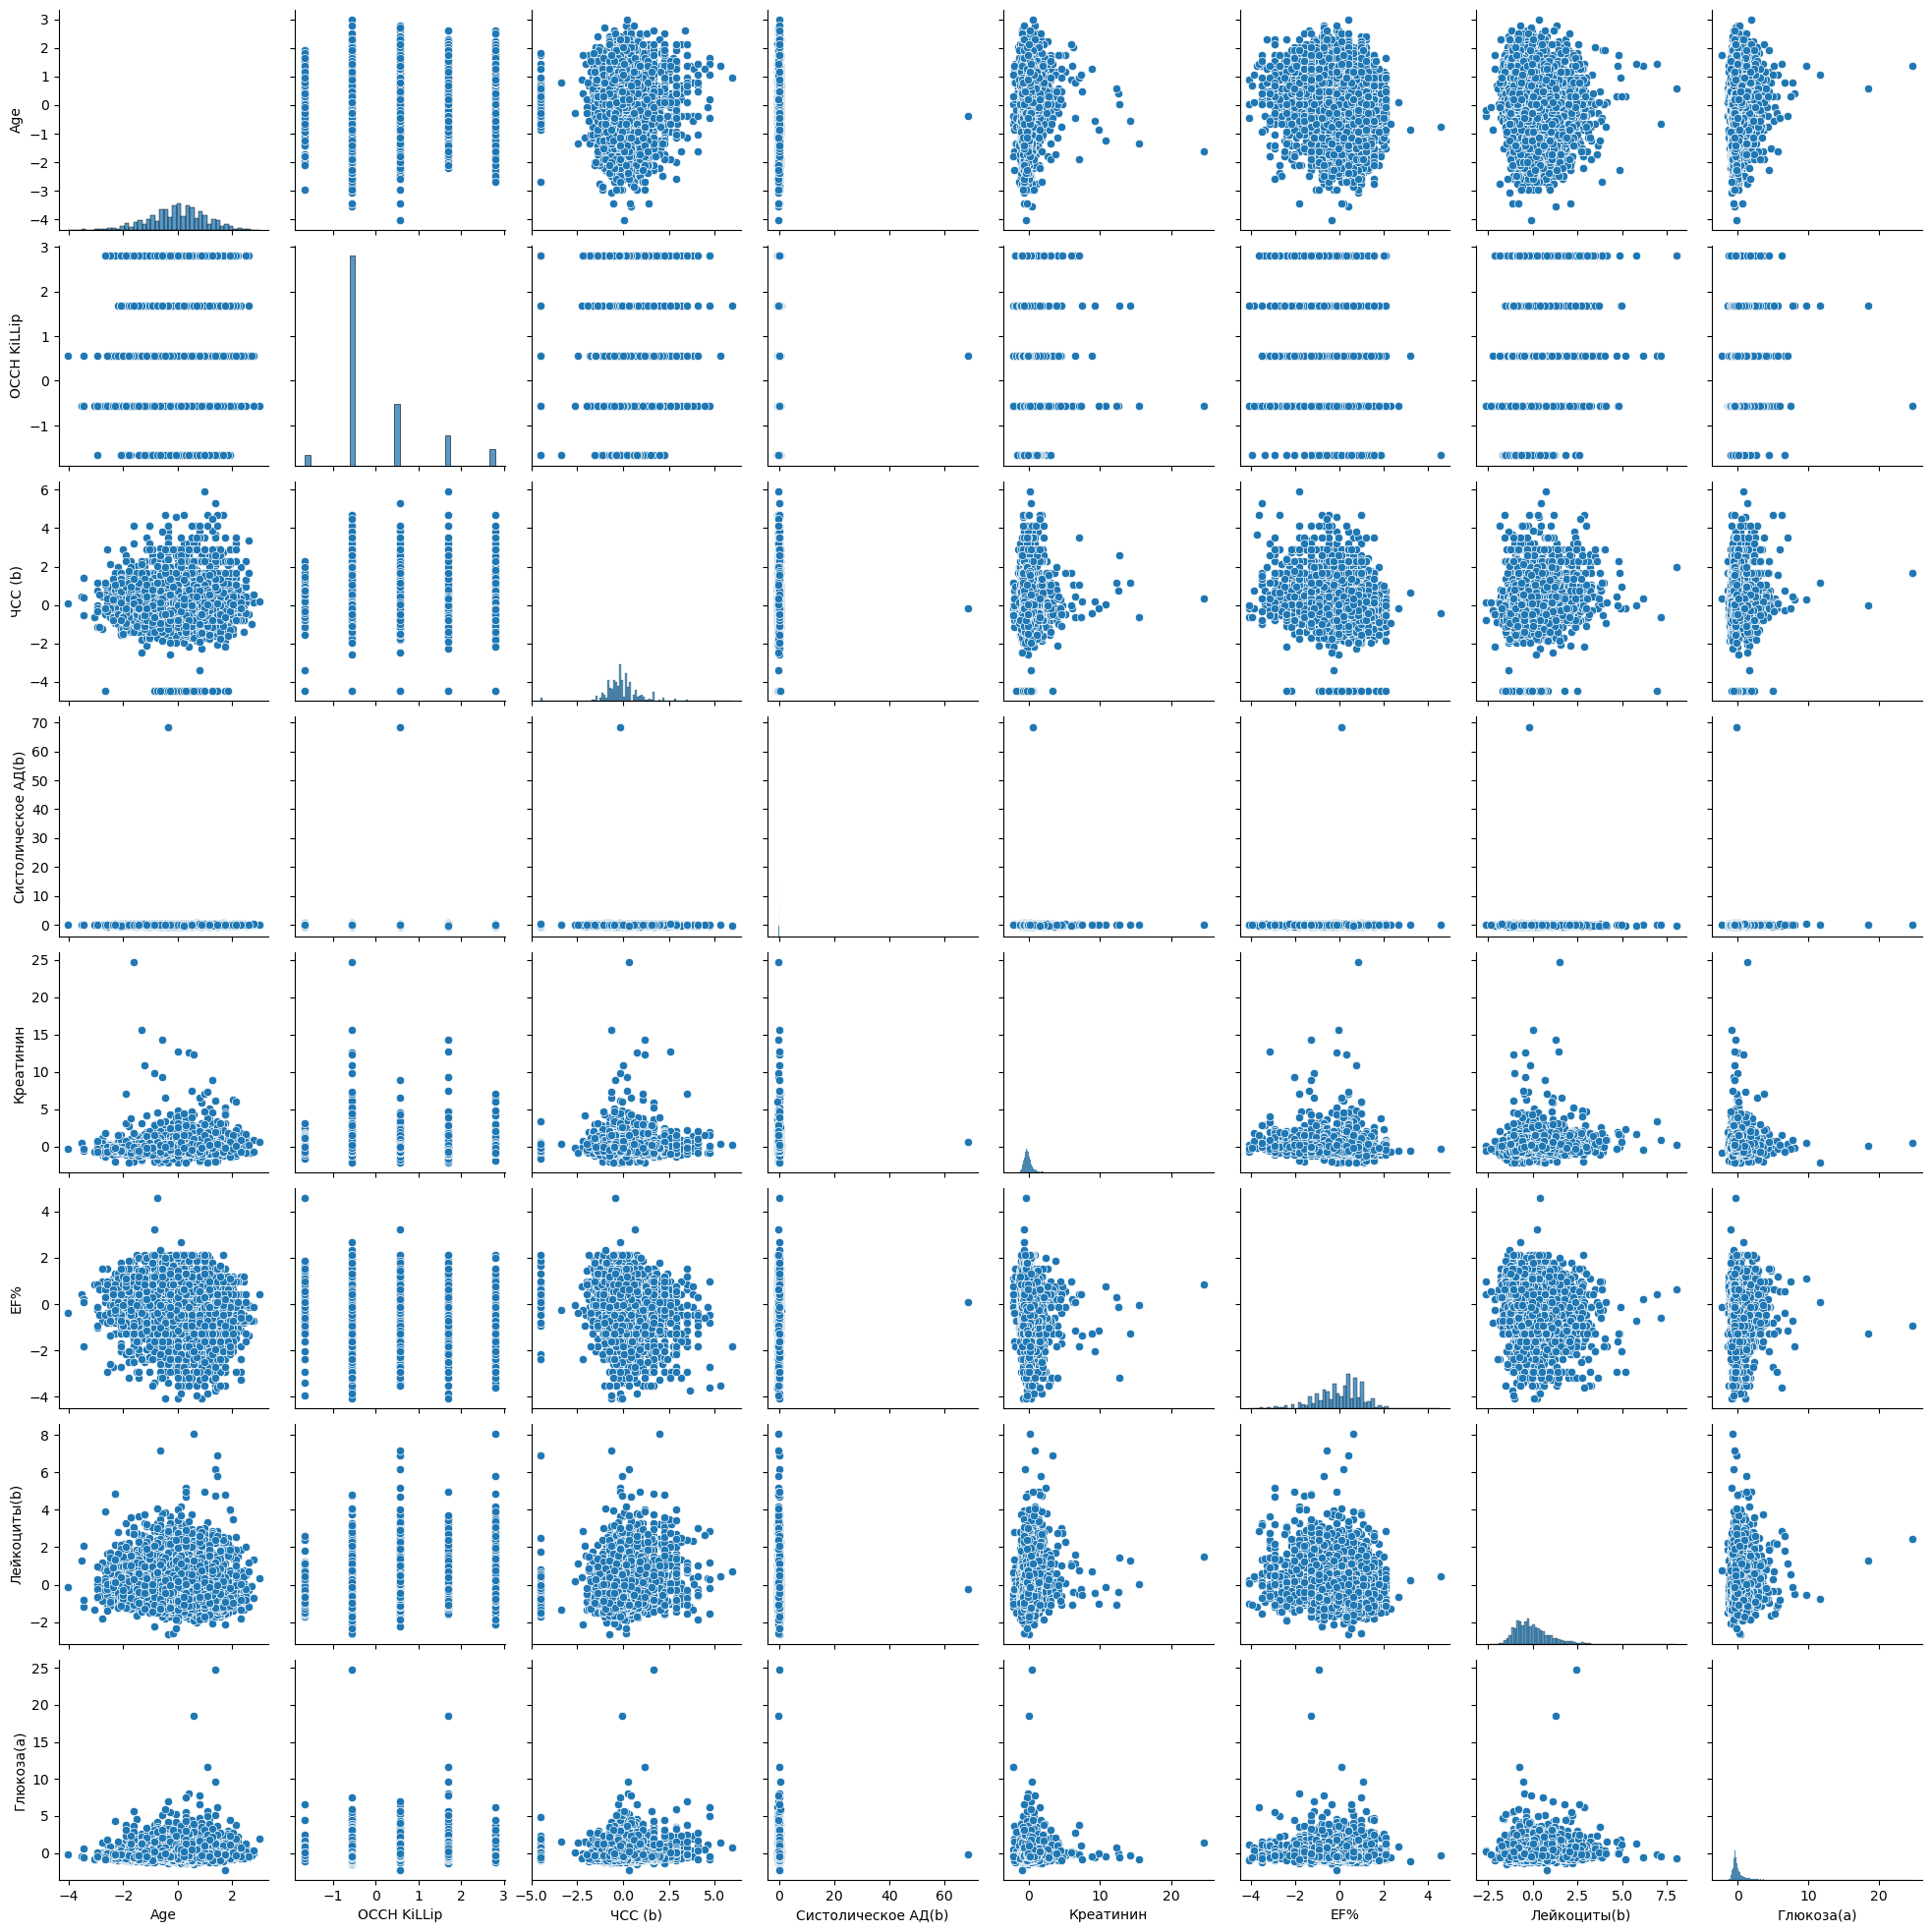

In [20]:
display(std_set['X_train'].describe())
sns.pairplot(std_set['X_train'])
plt.show()

,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a)
count,4790.000000,4790.000000,4790.000000,4790.000000,4790.000000,4790.000000,4790.000000,4790.000000
mean,0.573438,0.373278,0.431083,0.010591,0.080318,0.470604,0.246328,0.083654
std,0.143074,0.223375,0.095892,0.014436,0.037302,0.115929,0.093688,0.037016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.479452,0.250000,0.385965,0.009307,0.063316,0.389610,0.178998,0.065305
50%,0.575342,0.250000,0.415205,0.010076,0.075000,0.493506,0.229117,0.074486
75%,0.671233,0.500000,0.473684,0.011614,0.088636,0.545455,0.293556,0.088969
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


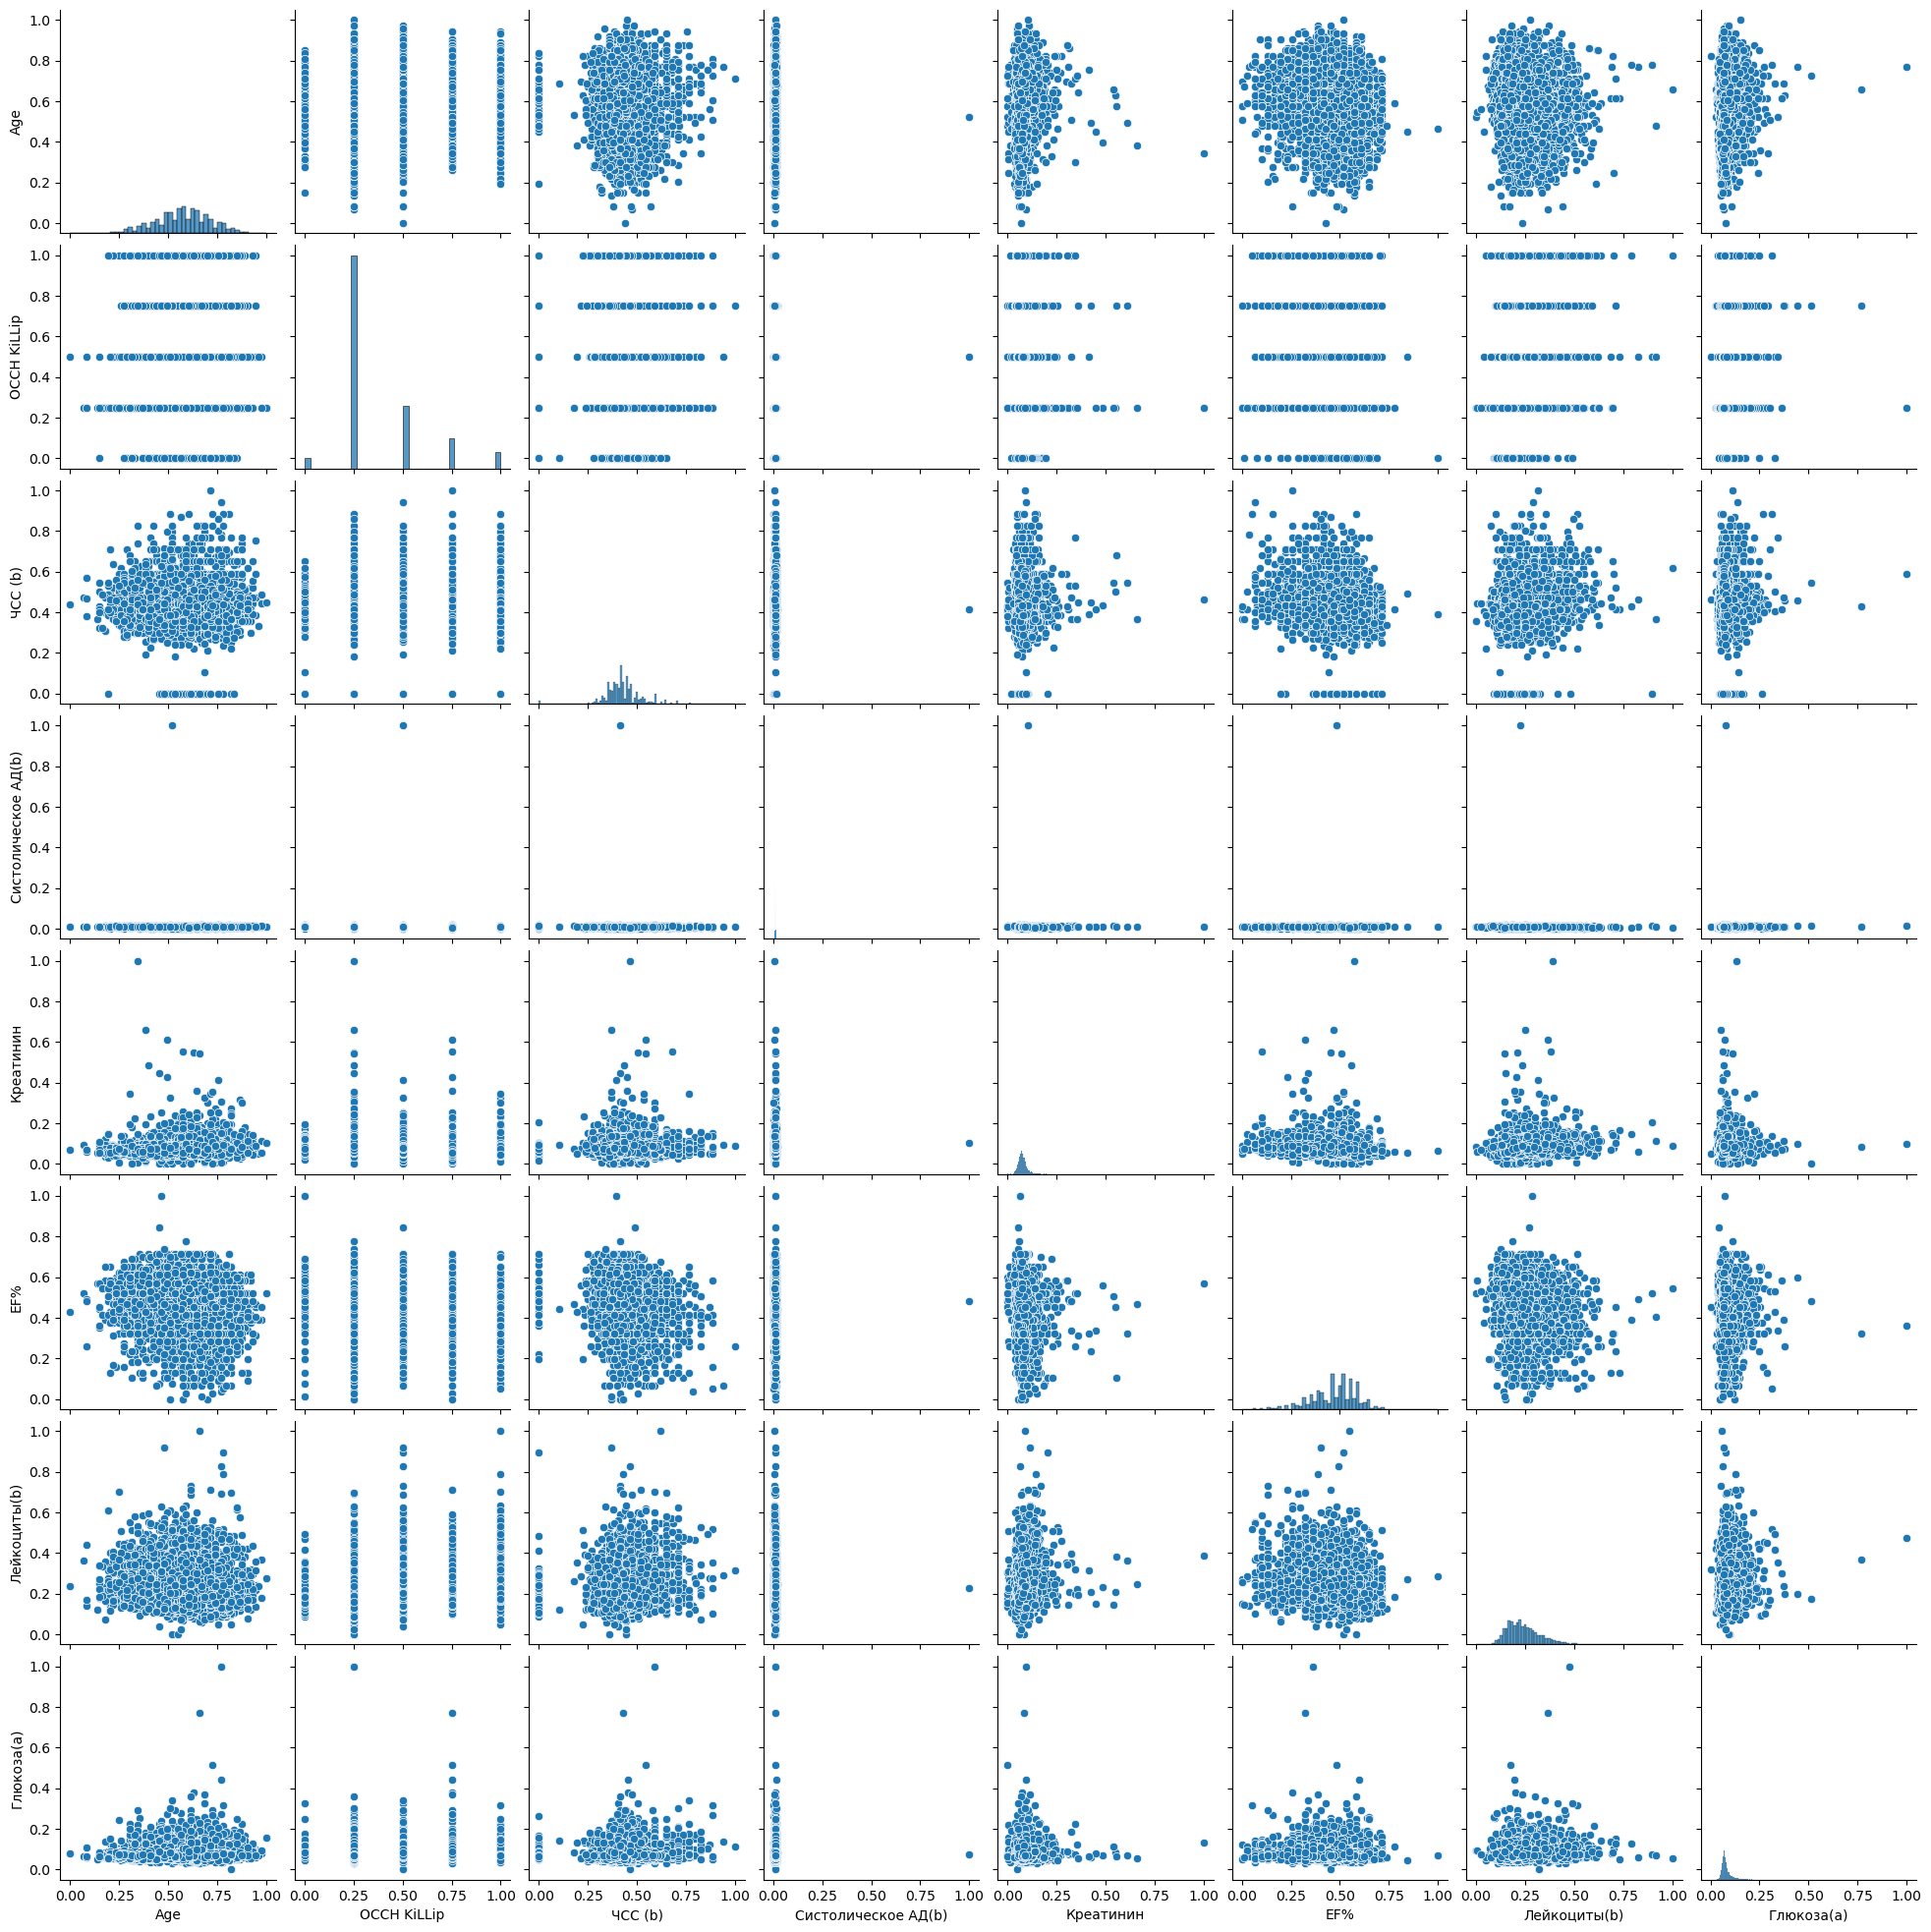

In [21]:
display(mm_set['X_train'].describe())
sns.pairplot(mm_set['X_train'])
plt.show()

There are different algorithms for calculating SHAP values:

1. Kernel SHAP: This method is model-agnostic and uses a weighted linear regression to estimate SHAP values. It is computationally expensive, especially for large datasets, but provides accurate explanations for any model. Use this method when you have a model that is not tree-based or linear, and you need a model-agnostic explanation. It is computationally expensive, so it's not suitable for large datasets or real-time explanations.

2. Tree SHAP: This method is designed specifically for tree-based models, such as decision trees, random forests, and gradient boosting machines. Tree SHAP is computationally efficient and provides exact SHAP values for tree-based models.

3. Linear SHAP: This method is specific to linear models. It calculates SHAP values by multiplying the feature values by the coefficients of the linear model.

4. Deep SHAP (DeepLIFT SHAP): This method is tailored for deep learning models, such as neural networks. Deep SHAP combines the DeepLIFT algorithm with SHAP value estimation, providing explanations for complex deep learning models.

5. Partition SHAP: This method is model-agnostic and uses a combination of random partitioning and model evaluations to compute SHAP values. It is more scalable than Kernel SHAP, but may be less accurate in some cases.

6. Monte Carlo SHAP: This method approximates SHAP values using random sampling, making it more computationally efficient than Kernel SHAP, but potentially less accurate. It can be used with any model.

In [95]:
def compute_mean_abs_shap_values(model, data, shap_algorithm):
    if shap_algorithm == 'kernel':
        explainer = shap.KernelExplainer(model.predict, data['X_train'])
        shap_values = explainer.shap_values(data['X_test'])
        display(shap_values)
        return np.abs(shap_values).mean(axis=0)
    elif shap_algorithm == 'tree':
        explainer = shap.TreeExplainer(model, data['X_train'])
        shap_values = explainer(data['X_test'], check_additivity=False)
        return np.abs(shap_values.values).mean(axis=0) 
    elif shap_algorithm == 'linear':
        explainer = shap.LinearExplainer(model, data['X_train'])
    elif shap_algorithm == 'deep':
        explainer = shap.DeepExplainer(model, data['X_train'].values)
        shap_values = explainer.shap_values(data['X_test'])
        return np.abs(shap_values.values).mean(axis=0)
    elif shap_algorithm == 'partition':
        explainer = shap.PartitionExplainer(model.predict, data['X_train'])
    elif shap_algorithm == 'monte_carlo':
        explainer = shap.MonteCarloExplainer(model.predict, data['X_train'])
    elif shap_algorithm == 'gradient':
        explainer = shap.GradientExplainer(model, data['X_train'])
    else:
        raise ValueError("Invalid SHAP algorithm name. Valid options are: 'kernel', 'tree', 'linear', 'deep', 'partition', 'monte_carlo' or 'gradient'.")

    shap_values = explainer(data['X_test']) 
    mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

    return mean_abs_shap_values

4. Regression models

In [23]:
combined_weights_regression_df = None #this df contains weights of features calculated for regression models

In [24]:
def create_weights_df(feature_weights=None, model_info="", index_columns=X_train.columns, shap_values=None):
    # Create a MultiIndex for columns to include model_info and the corresponding values ('Weight', 'SHAP')
    columns = pd.MultiIndex.from_product([[model_info], ['Weight', 'SHAP']])

    # Create a DataFrame with feature names as index and feature_weights as 'Weight' values
    weights_df = pd.DataFrame(index=index_columns, columns=columns)
   
    if feature_weights is not None:
        weights_df[(model_info, 'Weight')] = feature_weights
    else:
        weights_df[(model_info, 'Weight')] = np.nan
    

    if shap_values is not None:
        weights_df[(model_info, 'SHAP')] = shap_values
    else:
        weights_df[(model_info, 'SHAP')] = np.nan

    return weights_df

Calculate weights for univariate linear regression.

In [25]:
def perform_univariate_linear_regression(scaled_data, model_info='')->pd.DataFrame:
    feature_weights = []
    for feature_name in  scaled_data['X_train'].columns:
        lr = LinearRegression()
        lr.fit( scaled_data['X_train'][[feature_name]], y_train)

        # Feature weight estimation
        feature_weights.append(lr.coef_[0])

    weights_df =create_weights_df(feature_weights, 
                                model_info=f'Univariate linear regression with {model_info}')
    return weights_df

Calculate weights and SHAP values for multivariate linear regression.

In [26]:
def perform_multivariate_linear_regression(scaled_data, model_info='')->pd.DataFrame:
    feature_weights = []

    lr_multi = LinearRegression()
    lr_multi.fit( scaled_data['X_train'], y_train)

    # Feature weight estimation
    feature_weights = lr_multi.coef_

    # Shapley values for Multivariate Linear Regression
    mean_abs_shap_values = compute_mean_abs_shap_values(lr_multi, 
                                                        scaled_data, 
                                                        shap_algorithm='linear')
    
    weights_df = create_weights_df(feature_weights,                                   
                                    model_info=f'Multivariate linear regression with {model_info}',
                                    shap_values=mean_abs_shap_values)
    return weights_df

Calculate weights and shap values for logistic regression model

In [27]:
from sklearn.linear_model import LogisticRegression

def perform_logistic_regression(scaled_data, model_info=''):
    feature_weights = []

    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit( scaled_data['X_train'], y_train)

    # Feature weight estimation
    feature_weights = log_reg.coef_[0]

    # Shapley values for Logistic Regression
    mean_abs_shap_values = compute_mean_abs_shap_values(log_reg, 
                                                        scaled_data, 
                                                        shap_algorithm='linear')

    weights_df = create_weights_df(feature_weights,
                                    model_info=f'Logistic regression with {model_info}',
                                    shap_values=mean_abs_shap_values)
    return weights_df

Put all weight and shap values together

In [37]:
univariate_weights_orgnl_df = perform_univariate_linear_regression(original_set, model_info='NoScaler')
univariate_weights_std_df = perform_univariate_linear_regression(std_set, model_info='StandardScaler')
univariate_weights_mm_df = perform_univariate_linear_regression(mm_set, model_info='MinMaxScaler')

multivariate_weights_orgnl_shap_df = perform_multivariate_linear_regression(original_set, model_info='NoScaler')
multivariate_weights_std_shap_df = perform_multivariate_linear_regression(std_set, model_info='StandardScaler')
multivariate_weights_mm_shap_df = perform_multivariate_linear_regression(mm_set, model_info='MinMaxScaler')

logistic_regression_std_df = perform_logistic_regression(std_set, model_info='StandardScaler')

combined_weights_regression_df = pd.concat([univariate_weights_orgnl_df,
                                 univariate_weights_std_df,
                                 univariate_weights_mm_df,
                                 multivariate_weights_orgnl_shap_df,
                                 multivariate_weights_std_shap_df,
                                 multivariate_weights_mm_shap_df,
                                 logistic_regression_std_df
                                 ], axis=1)

In [ ]:
display(combined_weights_regression_df)
display(combined_weights_regression_df.describe())

Univariate linear regression with NoScaler       \
                                                        Weight SHAP   
Age                                                   0.001002  NaN   
ОССН KiLLip                                           0.025369  NaN   
ЧСС (b)                                               0.001340  NaN   
Систолическое АД(b)                                  -0.000011  NaN   
Креатинин                                             0.000585  NaN   
EF%                                                  -0.002672  NaN   
Лейкоциты(b)                                          0.005368  NaN   
Глюкоза(a)                                            0.008830  NaN   

                    Univariate linear regression with StandardScaler       \
                                                              Weight SHAP   
Age                                                         0.010432  NaN   
ОССН KiLLip                                                 0.022665  NaN   
ЧСС (b)                                                     0.022020  NaN   
Систолическое АД(b)                                        -0.002095  NaN   
Креатинин                                                   0.030517  NaN   
EF%                                                        -0.023877  NaN   
Лейкоциты(b)                                                0.021390  NaN   
Глюкоза(a)                                                  0.023330  NaN   

                    Univariate linear regression with MinMaxScaler       \
                                                            Weight SHAP   
Age                                                       0.073168  NaN   
ОССН KiLLip                                               0.101477  NaN   
ЧСС (b)                                                   0.215683  NaN   
Систолическое АД(b)                                      -0.145192  NaN   
Креатинин                                                 0.791997  NaN   
EF%                                                      -0.173695  NaN   
Лейкоциты(b)                                              0.224381  NaN   
Глюкоза(a)                                                0.349845  NaN   

                    Multivariate linear regression with NoScaler            \
                                                          Weight      SHAP   
Age                                                     0.000360  0.003115   
ОССН KiLLip                                             0.012559  0.008896   
ЧСС (b)                                                 0.000771  0.008569   
Систолическое АД(b)                                    -0.000008  0.000143   
Креатинин                                               0.000484  0.013769   
EF%                                                    -0.001430  0.010216   
Лейкоциты(b)                                            0.002263  0.006785   
Глюкоза(a)                                              0.006422  0.012355   

                    Multivariate linear regression with StandardScaler  \
                                                                Weight   
Age                                                           0.003746   
ОССН KiLLip                                                   0.011221   
ЧСС (b)                                                       0.012676   
Систолическое АД(b)                                          -0.001426   
Креатинин                                                     0.025248   
EF%                                                          -0.012774   
Лейкоциты(b)                                                  0.009017   
Глюкоза(a)                                                    0.016968   

                               \
                         SHAP   
Age                  0.002996   
ОССН KiLLip          0.008826   
ЧСС (b)              0.008777   
Систолическое АД(b)  0.001001   
Креатинин            0.012591   
EF%                  0.010032   
Л

Univariate linear regression with NoScaler       \
                                          Weight SHAP   
count                                   8.000000  0.0   
mean                                    0.004976  NaN   
std                                     0.008965  NaN   
min                                    -0.002672  NaN   
25%                                     0.000436  NaN   
50%                                     0.001171  NaN   
75%                                     0.006233  NaN   
max                                     0.025369  NaN   

      Univariate linear regression with StandardScaler       \
                                                Weight SHAP   
count                                         8.000000  0.0   
mean                                          0.013048  NaN   
std                                           0.017941  NaN   
min                                          -0.023877  NaN   
25%                                           0.007300  NaN   
50%                                           0.021705  NaN   
75%                                           0.022832  NaN   
max                                           0.030517  NaN   

      Univariate linear regression with MinMaxScaler       \
                                              Weight SHAP   
count                                       8.000000  0.0   
mean                                        0.179708  NaN   
std                                         0.305908  NaN   
min                                        -0.173695  NaN   
25%                                         0.018578  NaN   
50%                                         0.158580  NaN   
75%                                         0.255747  NaN   
max                                         0.791997  NaN   

      Multivariate linear regression with NoScaler            \
                                            Weight      SHAP   
count                                     8.000000  8.000000   
mean                                      0.002678  0.007981   
std                                       0.004625  0.004557   
min                                      -0.001430  0.000143   
25%                                       0.000268  0.005867   
50%                                       0.000628  0.008732   
75%                                       0.003303  0.010750   
max                                       0.012559  0.013769   

      Multivariate linear regression with StandardScaler            \
                                                  Weight      SHAP   
count                                           8.000000  8.000000   
mean                                            0.008084  0.007351   
std                                             0.011647  0.003747   
min                                            -0.012774  0.001001   
25%                                             0.002453  0.006039   
50%                                             0.010119  0.008154   
75%                                             0.013749  0.009128   
max                                             0.025248  0.012591   

      Multivariate linear regression with MinMaxScaler            \
                                                Weight      SHAP   
count                                         8.000000  8.000000   
mean                                          0.126649  0.017714   
std                                           0.242535  0.017387   
min                                          -0.098836  0.003457   
25%                                          -0.003524  0.008692   
50%                                           0.072412  0.009364   
75%                                           0.156730  0.019245   
max                                           0.655257  0.053875   

      Logistic regression with StandardScaler            
                                       Weight      SHAP  
count                                8.000000  8.00000

Let's plot these values.

In [ ]:
def flatten_df(df)->pd.DataFrame:
    # We need to flatten the table
    long_format_df = df.reset_index().melt(id_vars='index', var_name=['Model Info', 'Value Type'], value_name='Value')
    long_format_df = long_format_df.rename(columns={'index': 'Feature'})

    # Filter out rows corresponding to the SHAP values for univariate regression, because they are NaN
    shap_mask = long_format_df['Value Type'] == 'SHAP'
    univariate_mask = long_format_df['Model Info'].str.startswith('Univariate')
    flat_df = long_format_df.loc[~(shap_mask & univariate_mask)]
    return flat_df

In [ ]:
def plot_values(flat_df, value_type='Weight'):
    weights_df = flat_df.loc[flat_df['Value Type'] == value_type]
    plt.figure(figsize=(15, 20))
    ax = sns.barplot(data=weights_df, x='Model Info', y='Value', hue='Feature', palette='deep')

    for p in ax.patches:
        y_offset = 3 if p.get_height() >= 0 else -15
        ax.annotate(f"{p.get_height():.3f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', 
                    fontsize=6, color='black', 
                    xytext=(0, y_offset), textcoords='offset points')

    # plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', borderaxespad=0.)
    plt.xlabel('Feature')
    plt.ylabel('Value')
    plt.title(f'Feature {value_type} for Different Models')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

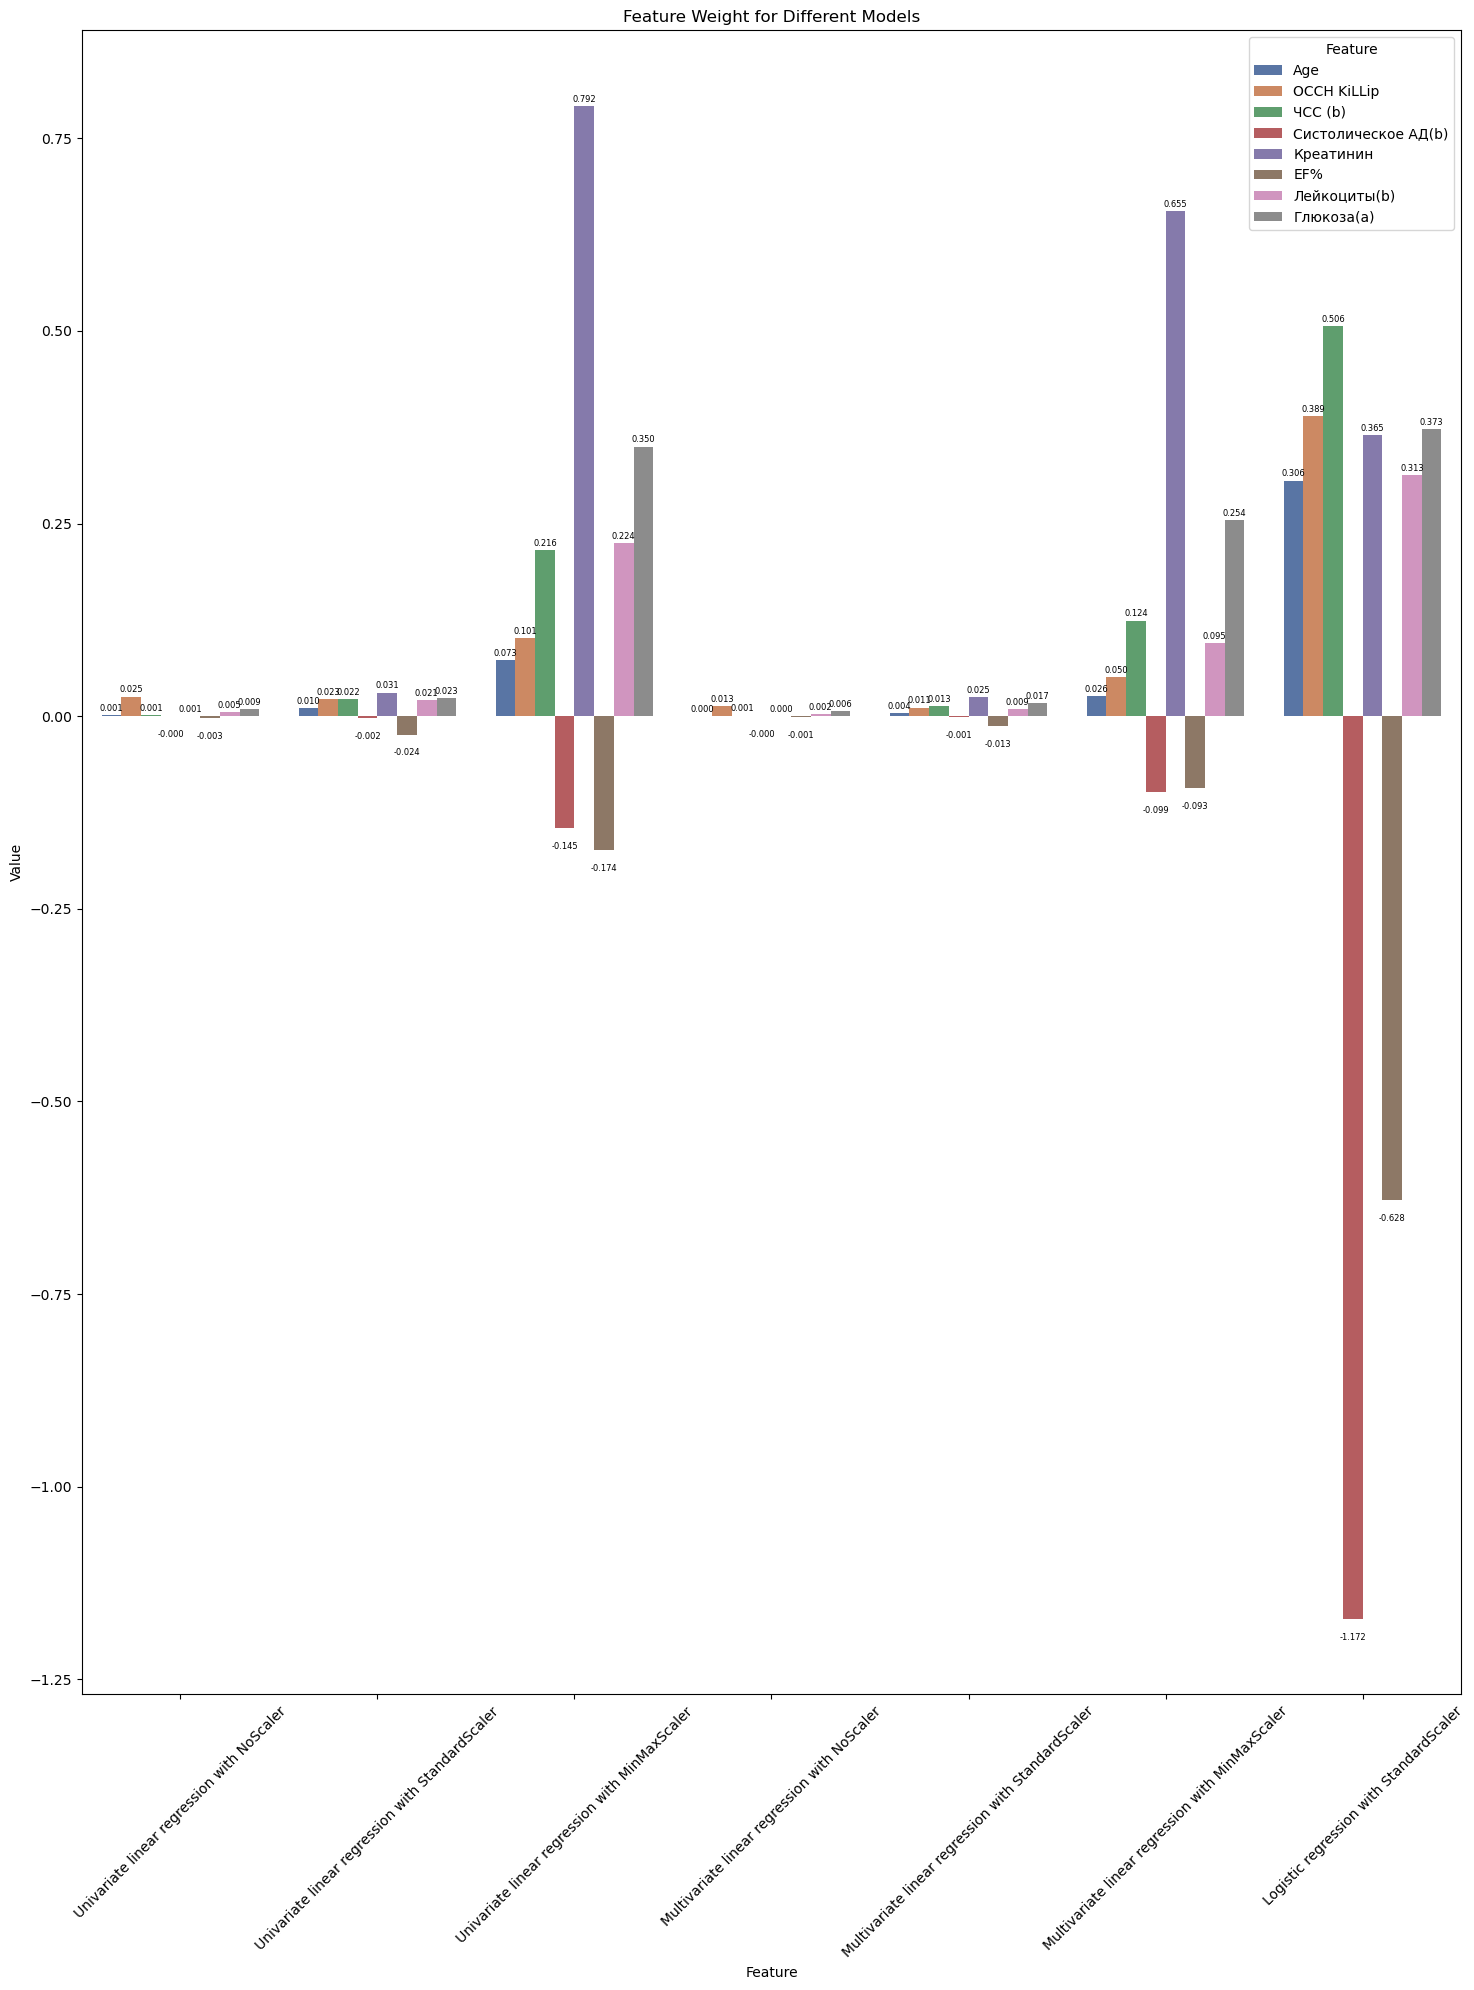

In [ ]:
plot_values(flatten_df(combined_weights_regression_df), "Weight")

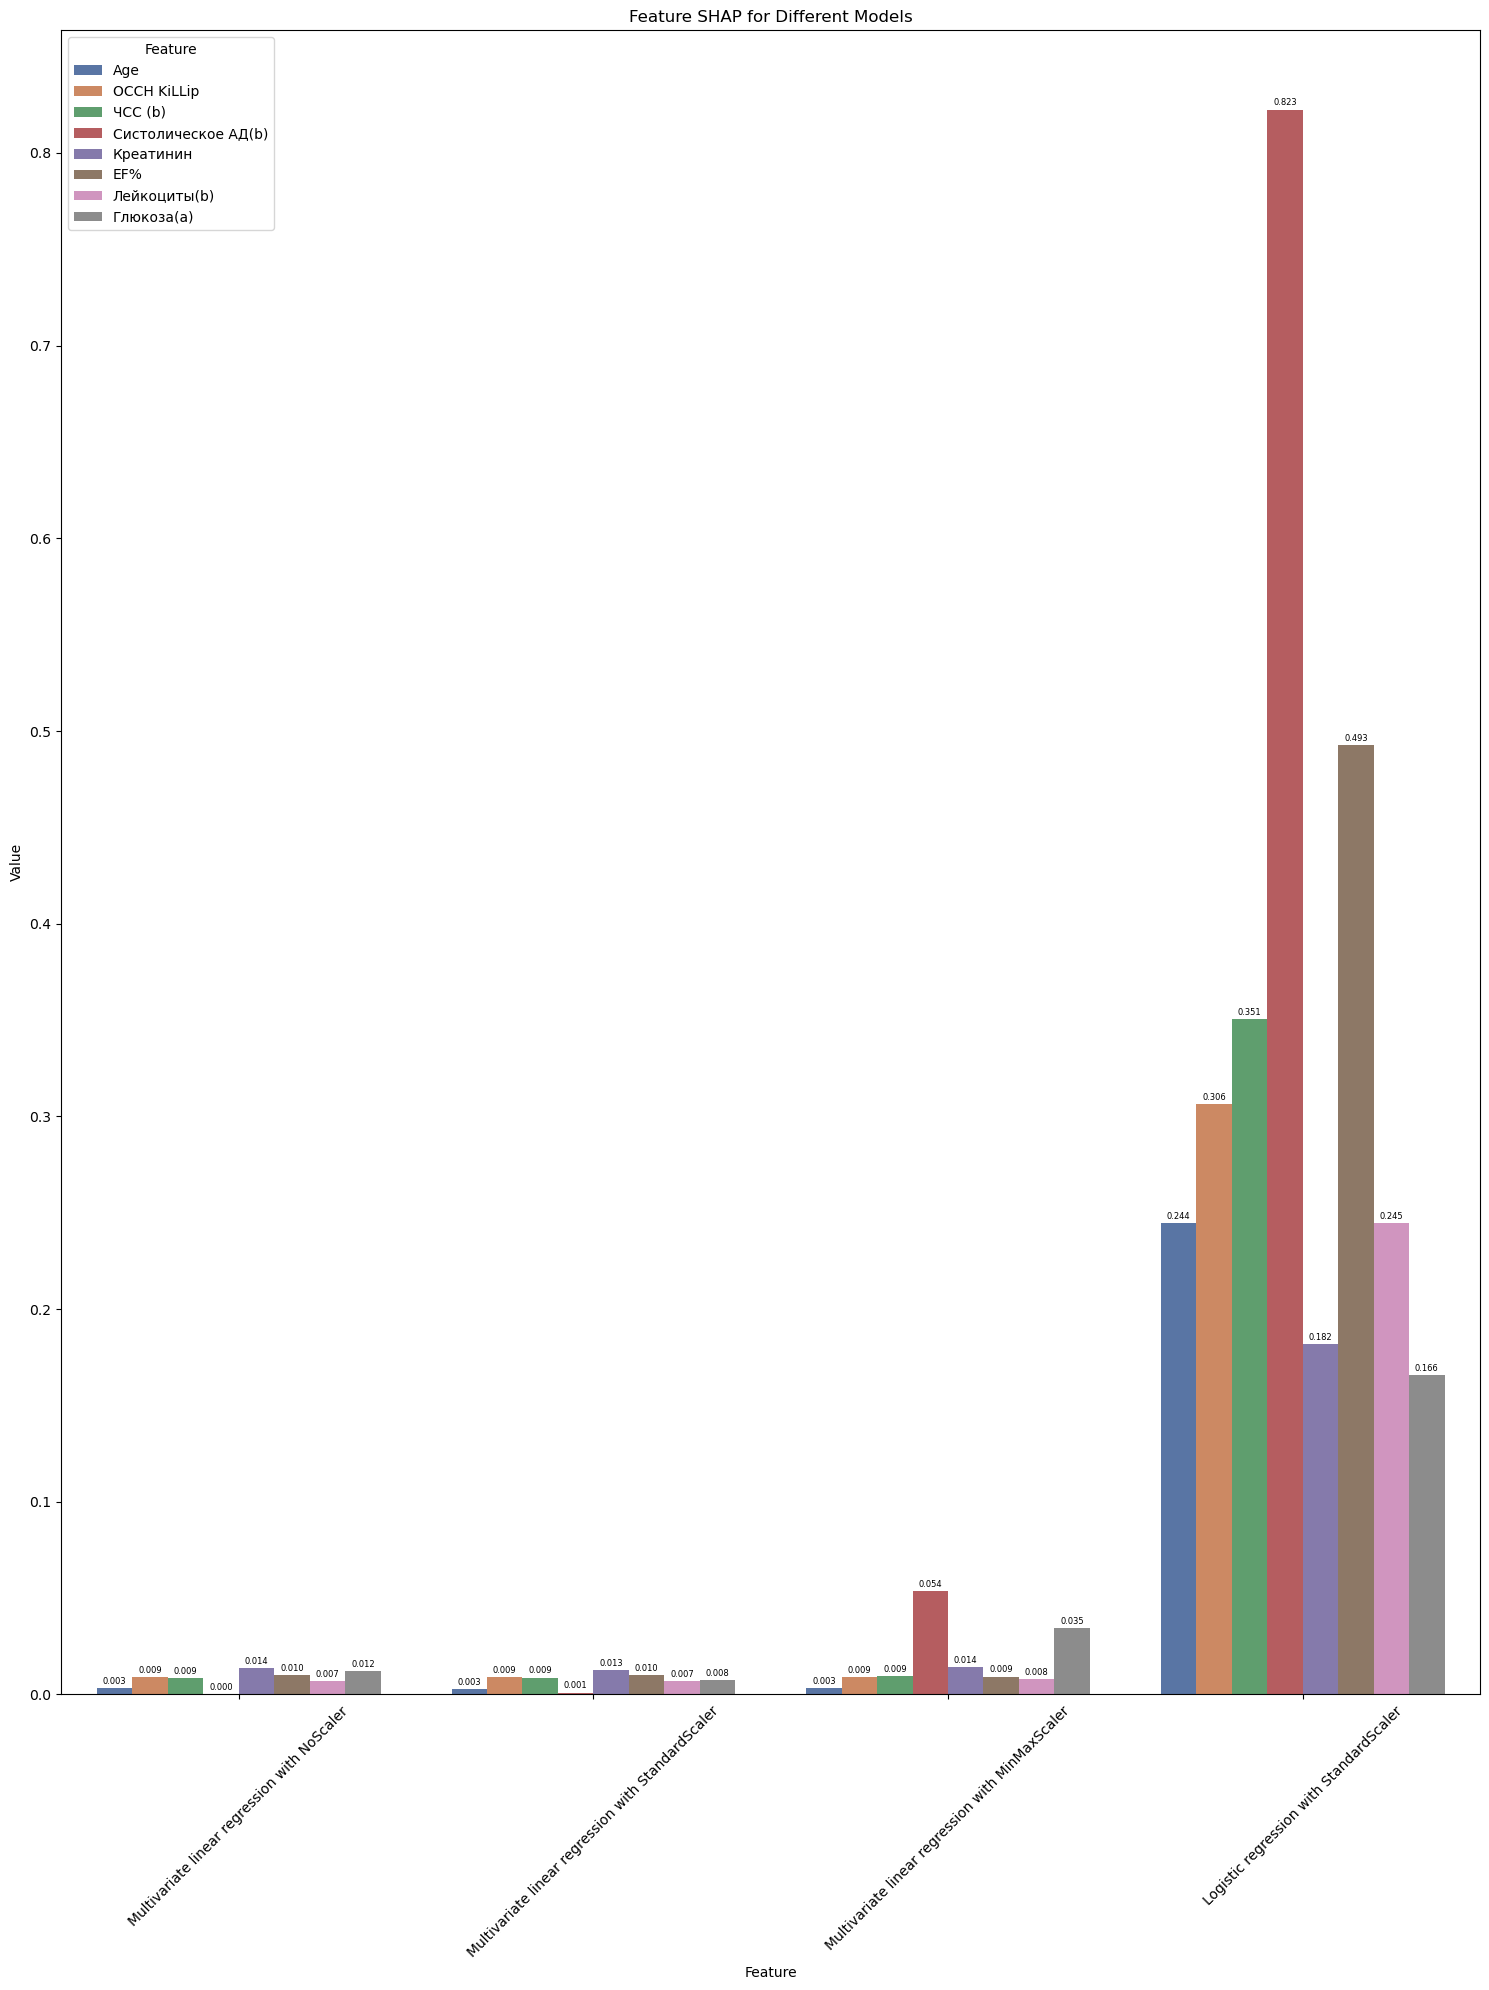

In [ ]:
plot_values(flatten_df(combined_weights_regression_df), "SHAP")

5. Gradient Boosting model

In [ ]:
combined_weights_tree_df = None #this df contains weights of features calculated for tree based models

In [ ]:
import xgboost as xgb

def perform_xgboost_regression(scaled_data, model_info=''):
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=25)
    xgb_model.fit(scaled_data['X_train'], y_train)
    

    # Feature importance using XGBoost's built-in feature importance metric
    feature_importances = xgb_model.feature_importances_

    # Shapley values for XGBoost Regression
    mean_abs_shap_values = compute_mean_abs_shap_values(xgb_model, 
                                                        scaled_data, 
                                                        shap_algorithm='tree')

    weights_df = create_weights_df(feature_importances,
                                    model_info=f'XGBoost regression - {model_info}',
                                    index_columns=scaled_data['X_train'].columns,
                                    shap_values=mean_abs_shap_values)
    return weights_df

6. Random Forest model

In [ ]:
def perform_forest_regression(scaled_data, model_info=''):
    rf_model = RandomForestRegressor(n_jobs=-1, random_state=25)
    rf_model.fit(scaled_data['X_train'], y_train)

    # Feature importance using RandomForest's built-in feature importance metric
    feature_importances = rf_model.feature_importances_

    # Shapley values for RandomForest Regression
    mean_abs_shap_values = compute_mean_abs_shap_values(rf_model, 
                                                        scaled_data, 
                                                        shap_algorithm='tree')

    weights_df = create_weights_df(feature_importances,
                                    model_info=f'RandomForest regression - {model_info}',
                                    index_columns=scaled_data['X_train'].columns,
                                    shap_values=mean_abs_shap_values)
    return weights_df

This function will change the order of columns for our tree models

In [ ]:
def carousel_wrapper(scaled_data, model_function, model_info=''):
    n_columns = len(scaled_data['X_train'].columns)
    all_weights_df = []

    for i in range(n_columns):
        # Rotate columns based on round-robin principle
        rotated_columns = np.roll(scaled_data['X_train'].columns, shift=-i)
        
        # Rearrange the columns in the dataset
        rotated_data = {}
        for key in scaled_data:
            # Assign the rotated columns to the data
            rotated_data[key] = scaled_data[key][rotated_columns]

        # Call the provided model_function with the new order of columns
        weights_df = model_function(rotated_data, model_info=f'{model_info} - Rotation {i+1}')
        all_weights_df.append(weights_df)
    
    # Combine all the weights dataframes into a single dataframe using join
    combined_weights_df = all_weights_df[0].join(all_weights_df[1:])

    return combined_weights_df


In [ ]:
xgboost_weights_shap_df = carousel_wrapper(original_set, perform_xgboost_regression)

In [ ]:
display(xgboost_weights_shap_df)
display(xgboost_weights_shap_df.describe())

XGBoost regression -  - Rotation 1            \
                                                Weight      SHAP   
Age                                           0.079619  0.006625   
ОССН KiLLip                                   0.081066  0.004462   
ЧСС (b)                                       0.127423  0.011177   
Систолическое АД(b)                           0.136706  0.004702   
Креатинин                                     0.156835  0.017871   
EF%                                           0.136080  0.015154   
Лейкоциты(b)                                  0.120550  0.010792   
Глюкоза(a)                                    0.161721  0.015322   

                    XGBoost regression -  - Rotation 2            \
                                                Weight      SHAP   
Age                                           0.129160  0.005841   
ОССН KiLLip                                   0.073493  0.004461   
ЧСС (b)                                       0.107963  0.011246   
Систолическое АД(b)                           0.136951  0.004567   
Креатинин                                     0.157840  0.017914   
EF%                                           0.118693  0.014408   
Лейкоциты(b)                                  0.133341  0.009705   
Глюкоза(a)                                    0.142558  0.015444   

                    XGBoost regression -  - Rotation 3            \
                                                Weight      SHAP   
Age                                           0.131091  0.005924   
ОССН KiLLip                                   0.067334  0.003895   
ЧСС (b)                                       0.105370  0.012108   
Систолическое АД(b)                           0.131080  0.004891   
Креатинин                                     0.159668  0.017277   
EF%                                           0.121270  0.013921   
Лейкоциты(b)                                  0.138515  0.009804   
Глюкоза(a)                                    0.145673  0.016328   

                    XGBoost regression -  - Rotation 4            \
                                                Weight      SHAP   
Age                                           0.106281  0.005445   
ОССН KiLLip                                   0.060953  0.002444   
ЧСС (b)                                       0.140064  0.010256   
Систолическое АД(b)                           0.094495  0.004868   
Креатинин                                     0.154070  0.018282   
EF%                                           0.139348  0.014372   
Лейкоциты(b)                                  0.138683  0.012522   
Глюкоза(a)                                    0.166105  0.016429   

                    XGBoost regression -  - Rotation 5            \
                                                Weight      SHAP   
Age                                           0.103124  0.005623   
ОССН KiLLip                                   0.077929  0.003369   
ЧСС (b)                                       0.135654  0.010415   
Систолическое АД(b)                           0.130458  0.004075   
Креатинин                                     0.122427  0.017952   
EF%                                           0.133918  0.015045   
Лейкоциты(b)                                  0.134232  0.012840   
Глюкоза(a)                                    0.162259  0.016329   

                    XGBoost regression -  - Rotation 6            \
                                                Weight      SHAP   
Age                                           0.096427  0.005897   
ОССН KiLLip                                   0.083888  0.004273   
ЧСС (b)                                       0.153063  0.010291   
Систолическое АД(b)                           0.138694  0.004167   
Креатинин                                     0.151487  0.016288   
EF%                                           0.098340  0.016417   
Лейкоциты(b)                                  0.121995  0.012978   
Глю

XGBoost regression -  - Rotation 1            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.010763   
std                             0.030792  0.005131   
min                             0.079619  0.004462   
25%                             0.110679  0.006145   
50%                             0.131752  0.010984   
75%                             0.141738  0.015196   
max                             0.161721  0.017871   

      XGBoost regression -  - Rotation 2            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.010448   
std                             0.025633  0.005199   
min                             0.073493  0.004461   
25%                             0.116011  0.005522   
50%                             0.131251  0.010475   
75%                             0.138353  0.014667   
max                             0.157840  0.017914   

      XGBoost regression -  - Rotation 3            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.010519   
std                             0.028311  0.005219   
min                             0.067334  0.003895   
25%                             0.117295  0.005666   
50%                             0.131086  0.010956   
75%                             0.140305  0.014523   
max                             0.159668  0.017277   

      XGBoost regression -  - Rotation 4            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.010577   
std                             0.034924  0.005818   
min                             0.060953  0.002444   
25%                             0.103335  0.005301   
50%                             0.139016  0.011389   
75%                             0.143565  0.014887   
max                             0.166105  0.018282   

      XGBoost regression -  - Rotation 5            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.010706   
std                             0.025063  0.005747   
min                             0.077929  0.003369   
25%                             0.117602  0.005236   
50%                             0.132188  0.011627   
75%                             0.134587  0.015366   
max                             0.162259  0.017952   

      XGBoost regression -  - Rotation 6            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.010641   
std                             0.028959  0.005254   
min                             0.083888  0.004167   
25%                             0.097862  0.005491   
50%                             0.130345  0.011635   
75%                             0.151881  0.015185   
max                             0.156105  0.016417   

      XGBoost regression -  - Rotation 7            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.010610   
std                             0.028152  0.004862   
min                             0.081083  0.004356   
25%                             0.105711  0.005632   
50%                             0.133122  0.012472   
75%                             0.146403  0.014514   
max                             0.155881  0.015847   

      XGBoost regression -  - Rotation 8            
                                  Weight      SHAP  
count                           8.000000  8.000000  
mean                            0.125000  0.010572  
std    

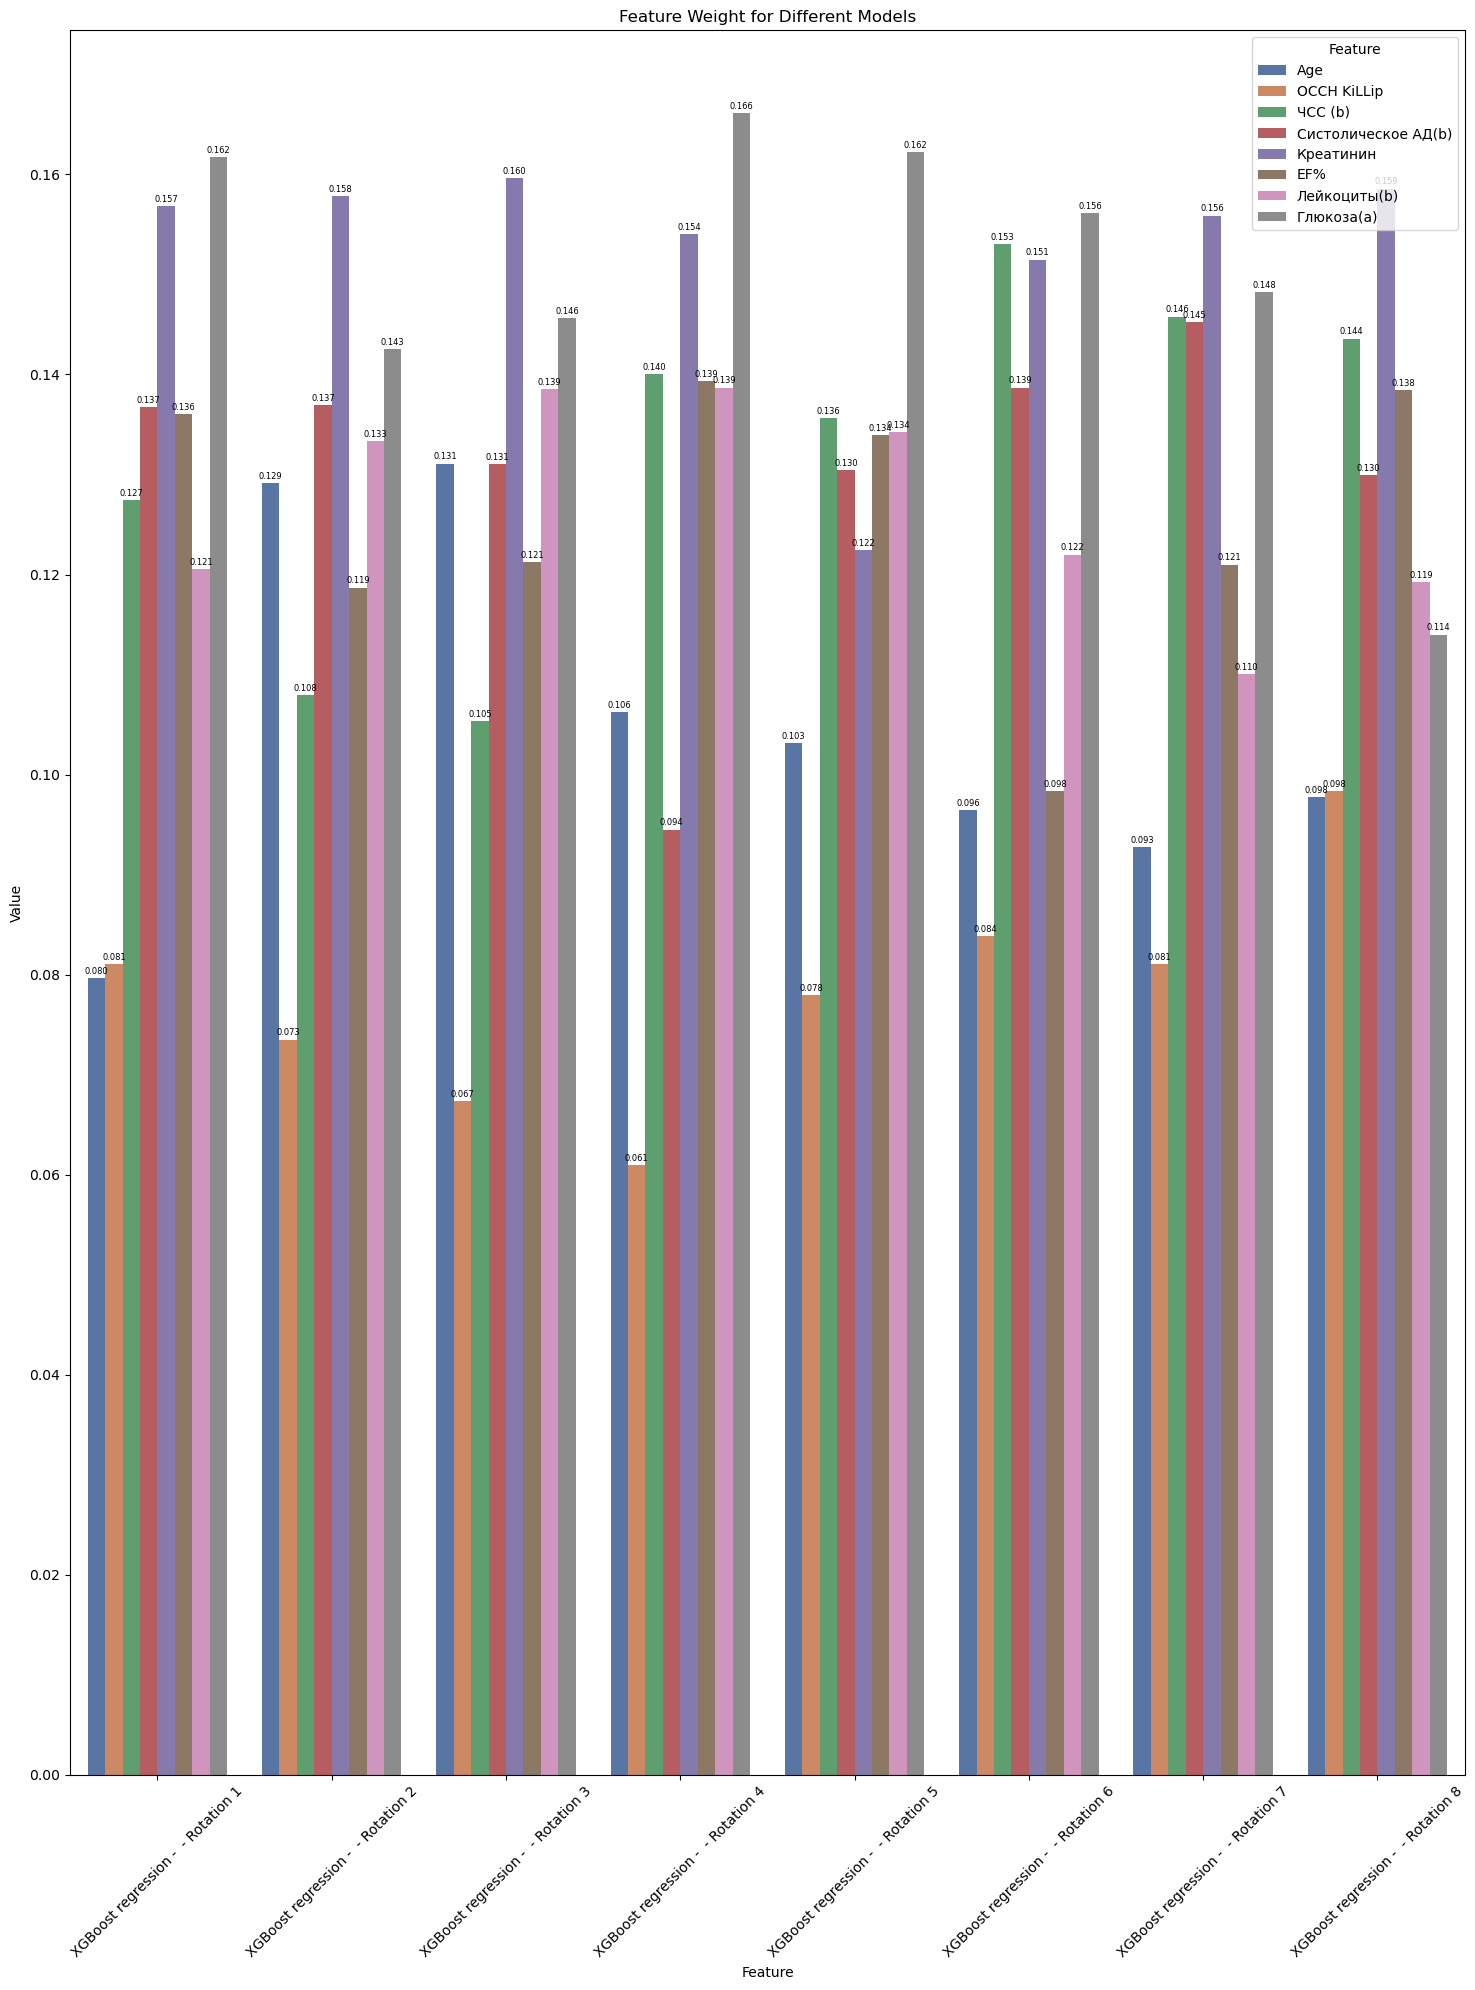

In [ ]:
plot_values(flatten_df(xgboost_weights_shap_df), "Weight")

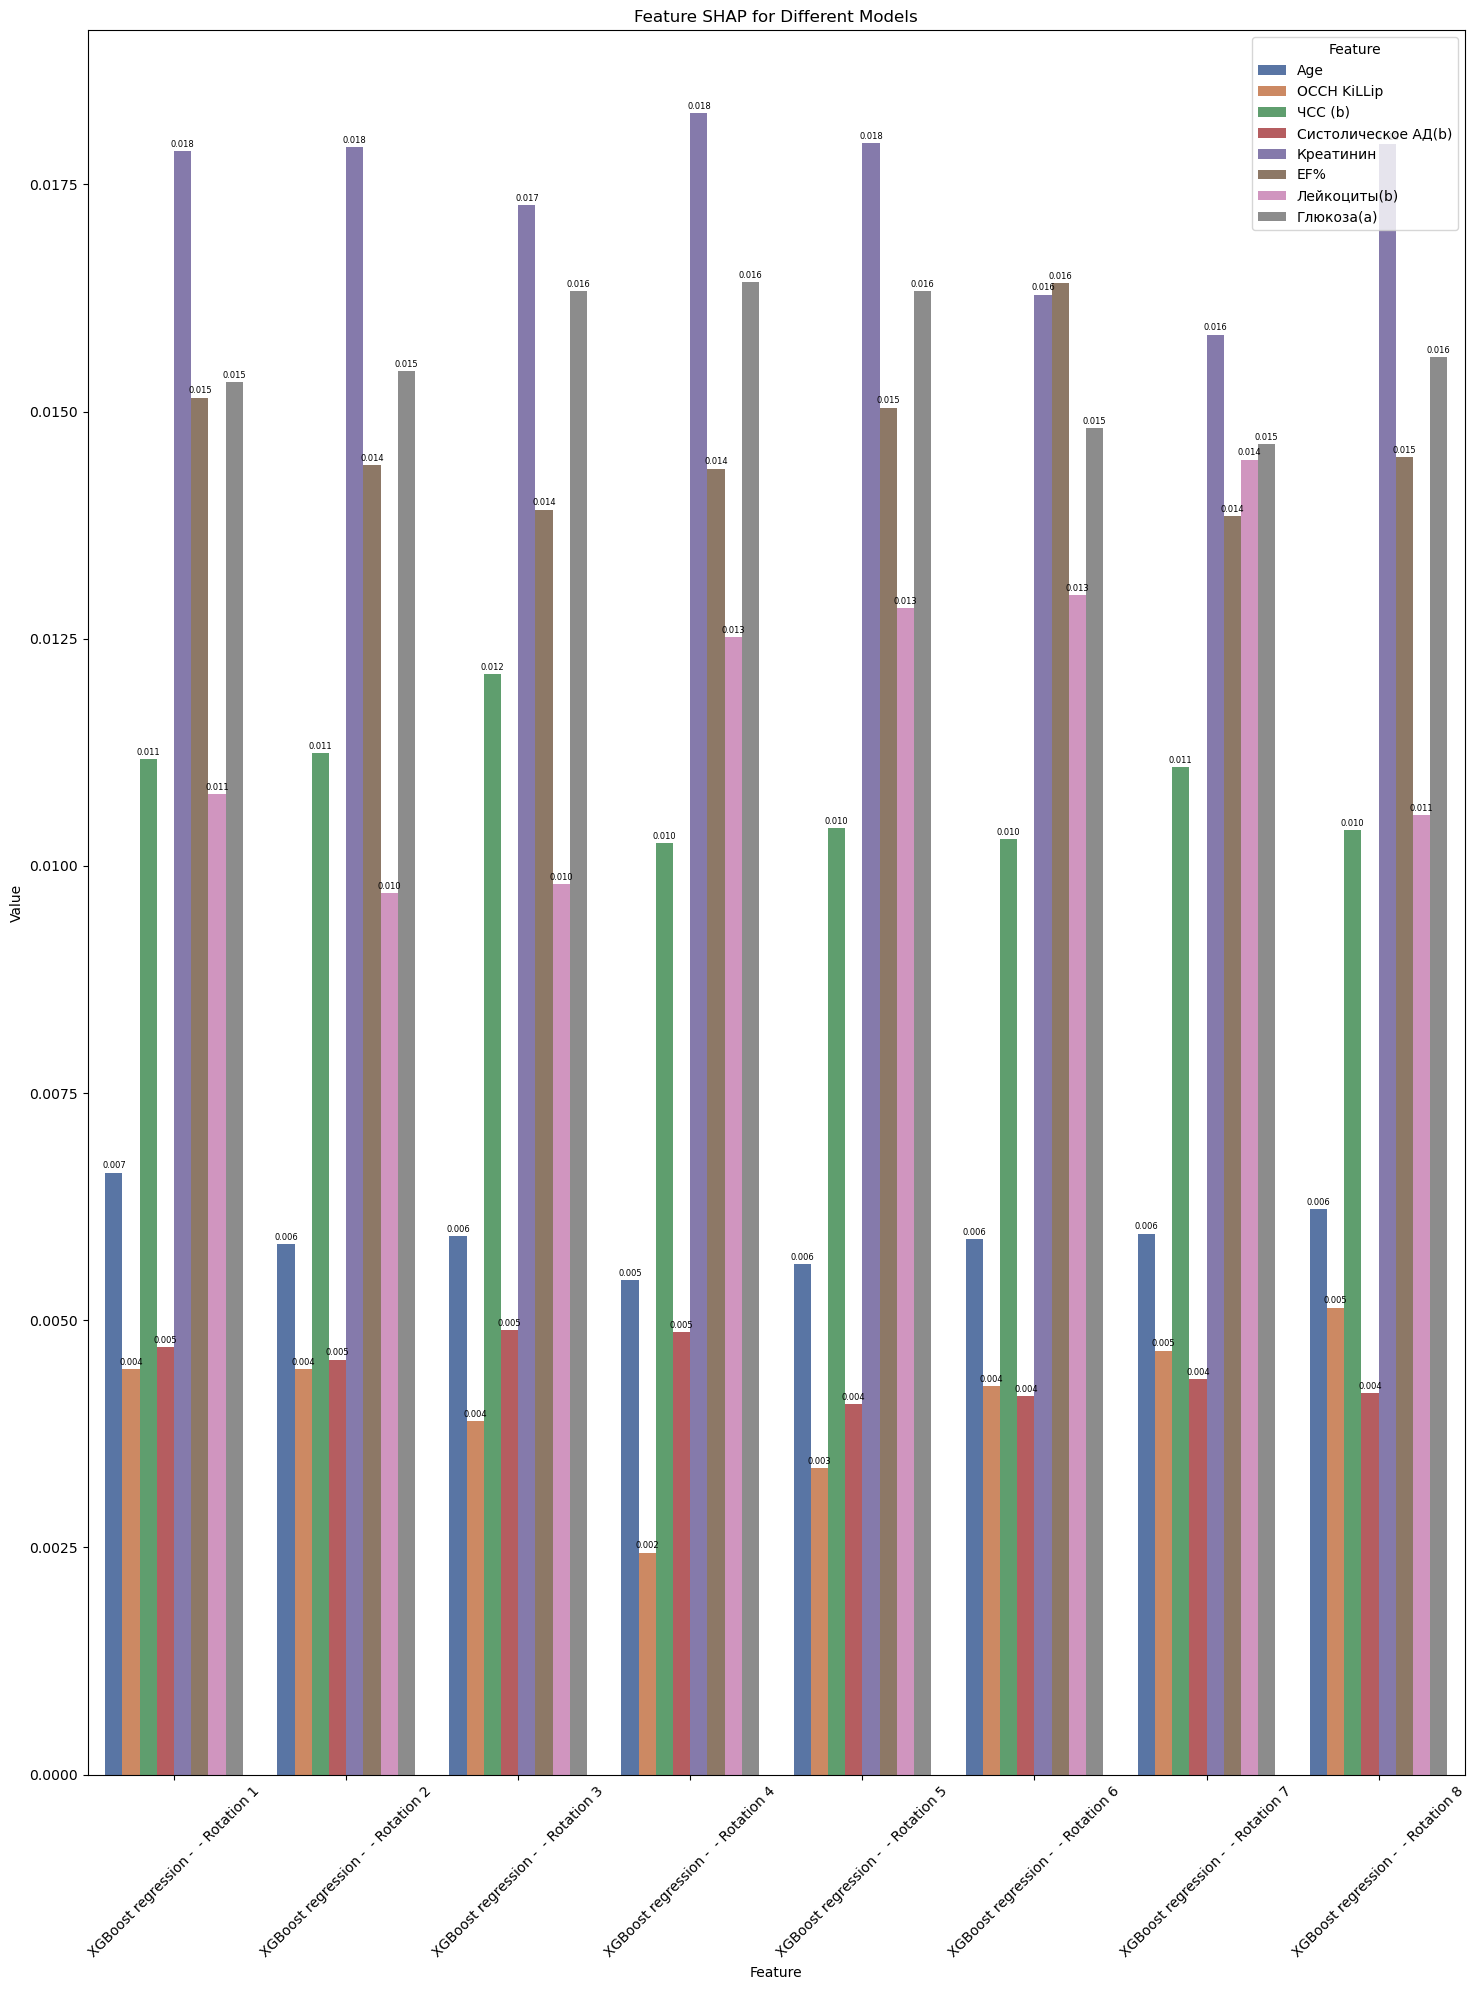

In [ ]:
plot_values(flatten_df(xgboost_weights_shap_df), "SHAP")

In [ ]:
forest_weights_shap_df = carousel_wrapper(original_set, perform_forest_regression)

 96%|=================== | 1148/1198 [00:11<00:00]       

In [ ]:
display(forest_weights_shap_df)
display(forest_weights_shap_df.describe())

RandomForest regression -  - Rotation 1            \
                                                     Weight      SHAP   
Age                                                0.092868  0.004304   
ОССН KiLLip                                        0.034986  0.003216   
ЧСС (b)                                            0.137766  0.009394   
Систолическое АД(b)                                0.092666  0.004272   
Креатинин                                          0.181714  0.012719   
EF%                                                0.125230  0.013534   
Лейкоциты(b)                                       0.138975  0.010563   
Глюкоза(a)                                         0.195795  0.012549   

                    RandomForest regression -  - Rotation 2            \
                                                     Weight      SHAP   
Age                                                0.095720  0.004240   
ОССН KiLLip                                        0.036442  0.003178   
ЧСС (b)                                            0.134129  0.009632   
Систолическое АД(b)                                0.094954  0.004232   
Креатинин                                          0.180936  0.012737   
EF%                                                0.125053  0.013415   
Лейкоциты(b)                                       0.138791  0.010840   
Глюкоза(a)                                         0.193975  0.012387   

                    RandomForest regression -  - Rotation 3            \
                                                     Weight      SHAP   
Age                                                0.095277  0.004436   
ОССН KiLLip                                        0.036348  0.003178   
ЧСС (b)                                            0.132382  0.009341   
Систолическое АД(b)                                0.091536  0.004373   
Креатинин                                          0.187318  0.012593   
EF%                                                0.122877  0.013255   
Лейкоциты(b)                                       0.137646  0.010821   
Глюкоза(a)                                         0.196616  0.012433   

                    RandomForest regression -  - Rotation 4            \
                                                     Weight      SHAP   
Age                                                0.094079  0.004277   
ОССН KiLLip                                        0.034858  0.003235   
ЧСС (b)                                            0.137014  0.009281   
Систолическое АД(b)                                0.093786  0.004002   
Креатинин                                          0.183349  0.012369   
EF%                                                0.124293  0.013157   
Лейкоциты(b)                                       0.138501  0.011032   
Глюкоза(a)                                         0.194120  0.012146   

                    RandomForest regression -  - Rotation 5            \
                                                     Weight      SHAP   
Age                                                0.092959  0.004383   
ОССН KiLLip                                        0.035561  0.003274   
ЧСС (b)                                            0.131580  0.009414   
Систолическое АД(b)                                0.096523  0.004365   
Креатинин                                          0.182534  0.012962   
EF%                                                0.125912  0.013559   
Лейкоциты(b)                                       0.139994  0.010997   
Глюкоза(a)                                         0.194937  0.012004   

                    RandomForest regression -  - Rotation 6            \
                                                     Weight      SHAP   
Age                                                0.095539  0.004396   
ОССН KiLLip                                        0.035084  0.003291   
ЧСС (b)                                            0.134675  0.009561   


RandomForest regression -  - Rotation 1            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.008819   
std                                  0.051779  0.004262   
min                                  0.034986  0.003216   
25%                                  0.092817  0.004296   
50%                                  0.131498  0.009978   
75%                                  0.149660  0.012591   
max                                  0.195795  0.013534   

      RandomForest regression -  - Rotation 2            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.008833   
std                                  0.050374  0.004272   
min                                  0.036442  0.003178   
25%                                  0.095528  0.004238   
50%                                  0.129591  0.010236   
75%                                  0.149327  0.012474   
max                                  0.193975  0.013415   

      RandomForest regression -  - Rotation 3            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.008804   
std                                  0.052227  0.004176   
min                                  0.036348  0.003178   
25%                                  0.094341  0.004420   
50%                                  0.127630  0.010081   
75%                                  0.150064  0.012473   
max                                  0.196616  0.013255   

      RandomForest regression -  - Rotation 4            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.008687   
std                                  0.051500  0.004183   
min                                  0.034858  0.003235   
25%                                  0.094005  0.004208   
50%                                  0.130654  0.010156   
75%                                  0.149713  0.012202   
max                                  0.194120  0.013157   

      RandomForest regression -  - Rotation 5            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.008870   
std                                  0.051140  0.004228   
min                                  0.035561  0.003274   
25%                                  0.095632  0.004378   
50%                                  0.128746  0.010206   
75%                                  0.150629  0.012244   
max                                  0.194937  0.013559   

      RandomForest regression -  - Rotation 6            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.008822   
std                                  0.051539  0.004243   
min                                  0.035084  0.003291   
25%                                  0.094606  0.004311   
50%                                  0.130263  0.010167   
75%                                  0.150087  0.012424   
max                                  0.195375  0.013310   

      RandomForest regression -  - Rotation 7            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.008760   
std                                  0.051437  0.004173   
min                                  0.034744  0.003256   
25%                                  0.095031  0.004389   
50%                                  0.129304  

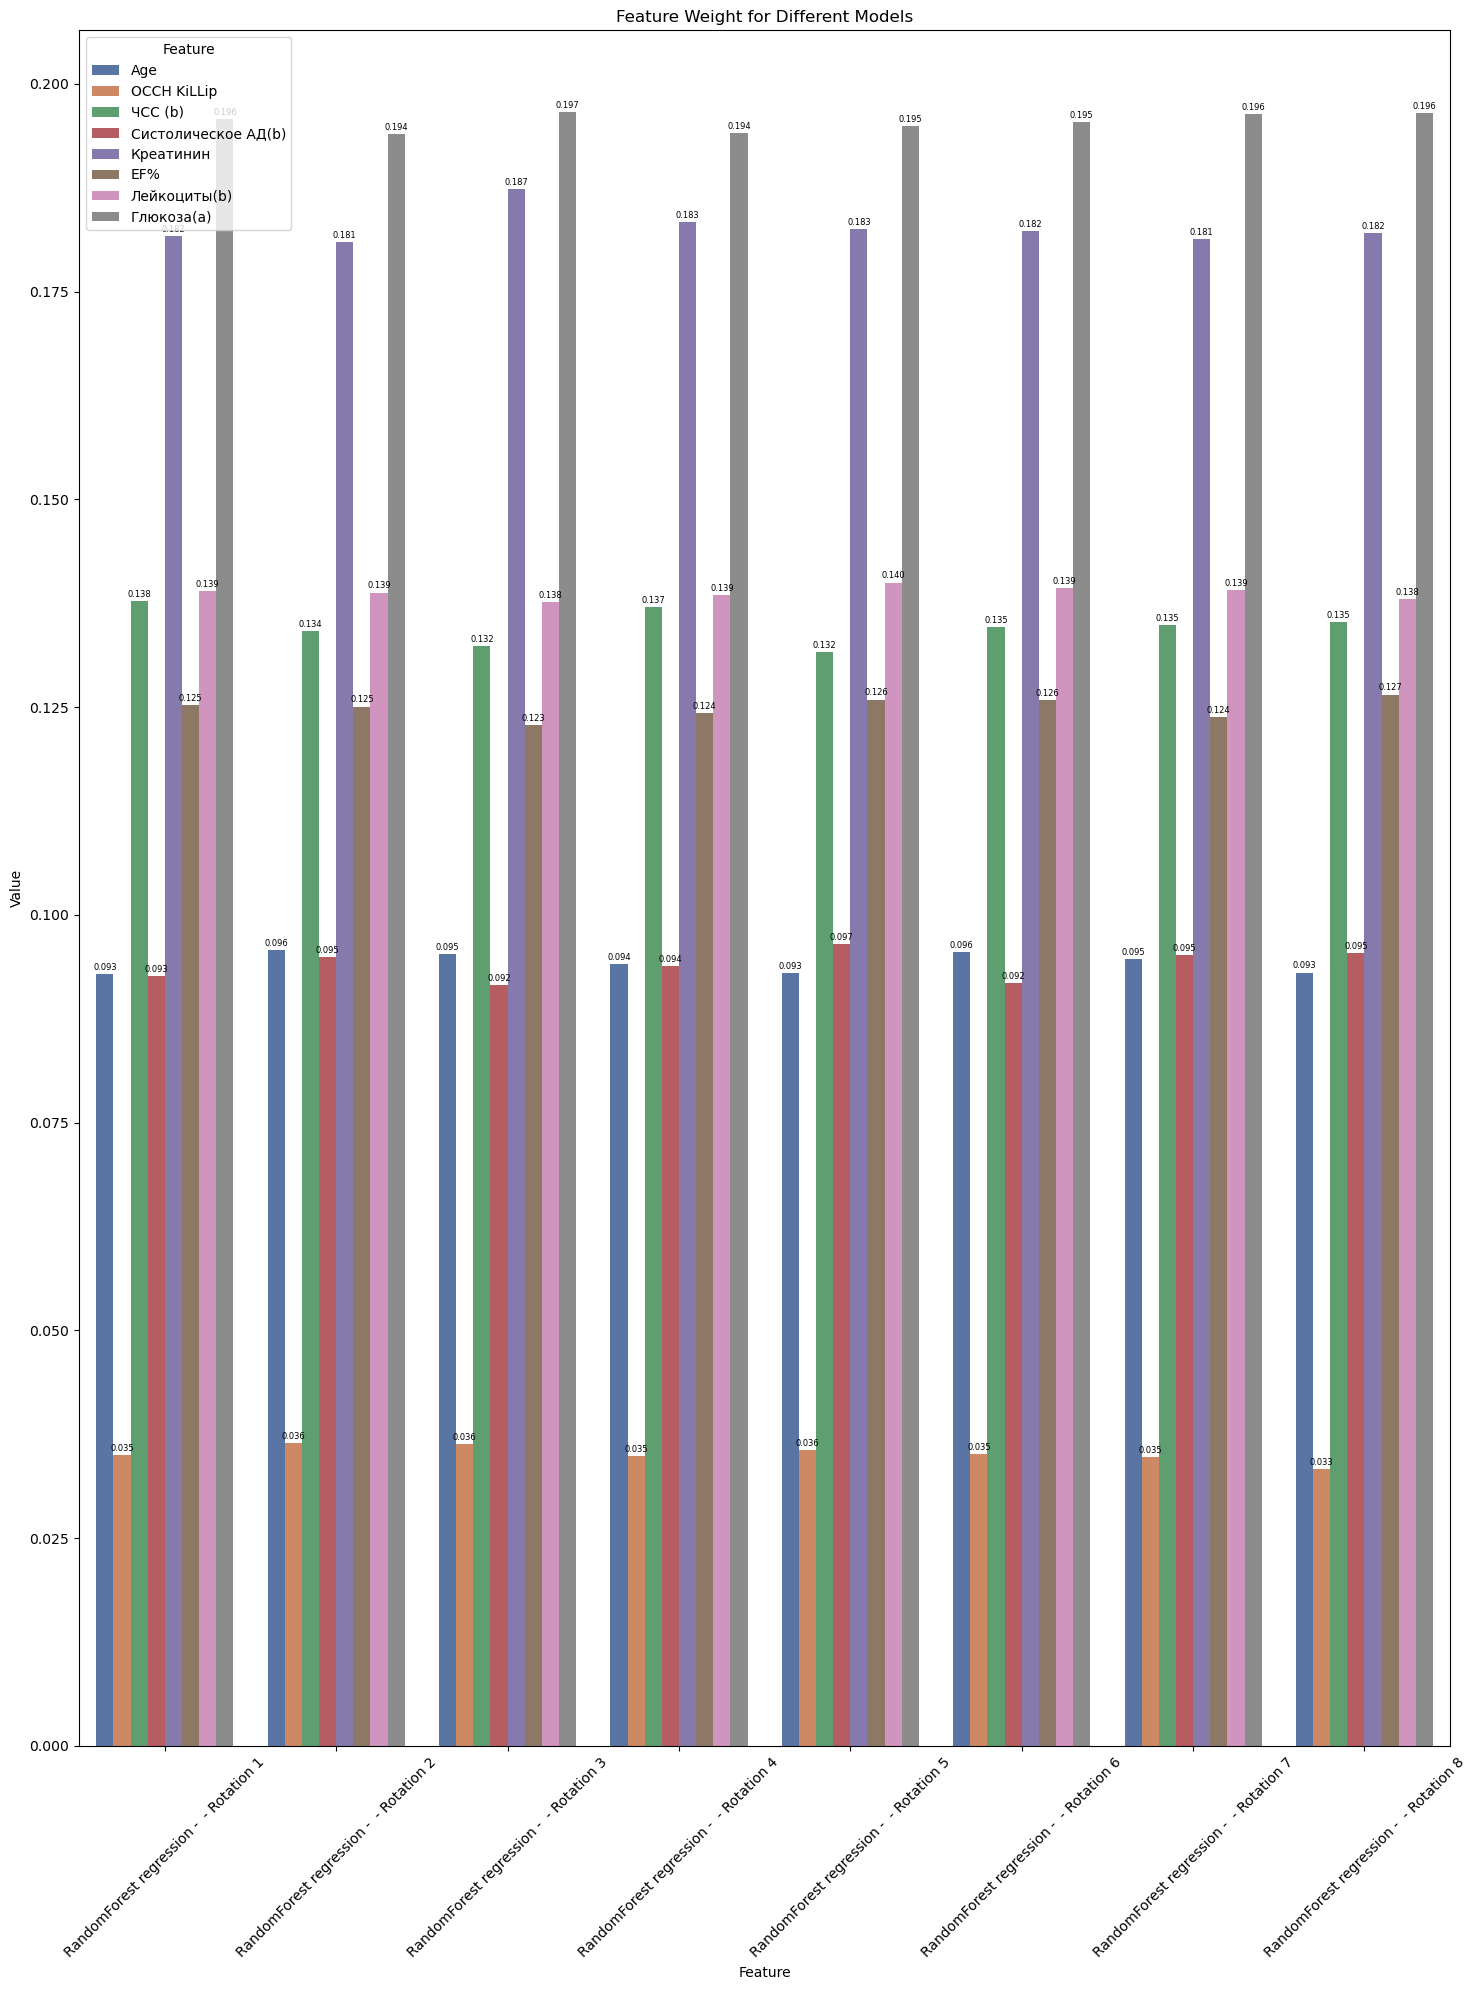

In [ ]:
plot_values(flatten_df(forest_weights_shap_df), "Weight")

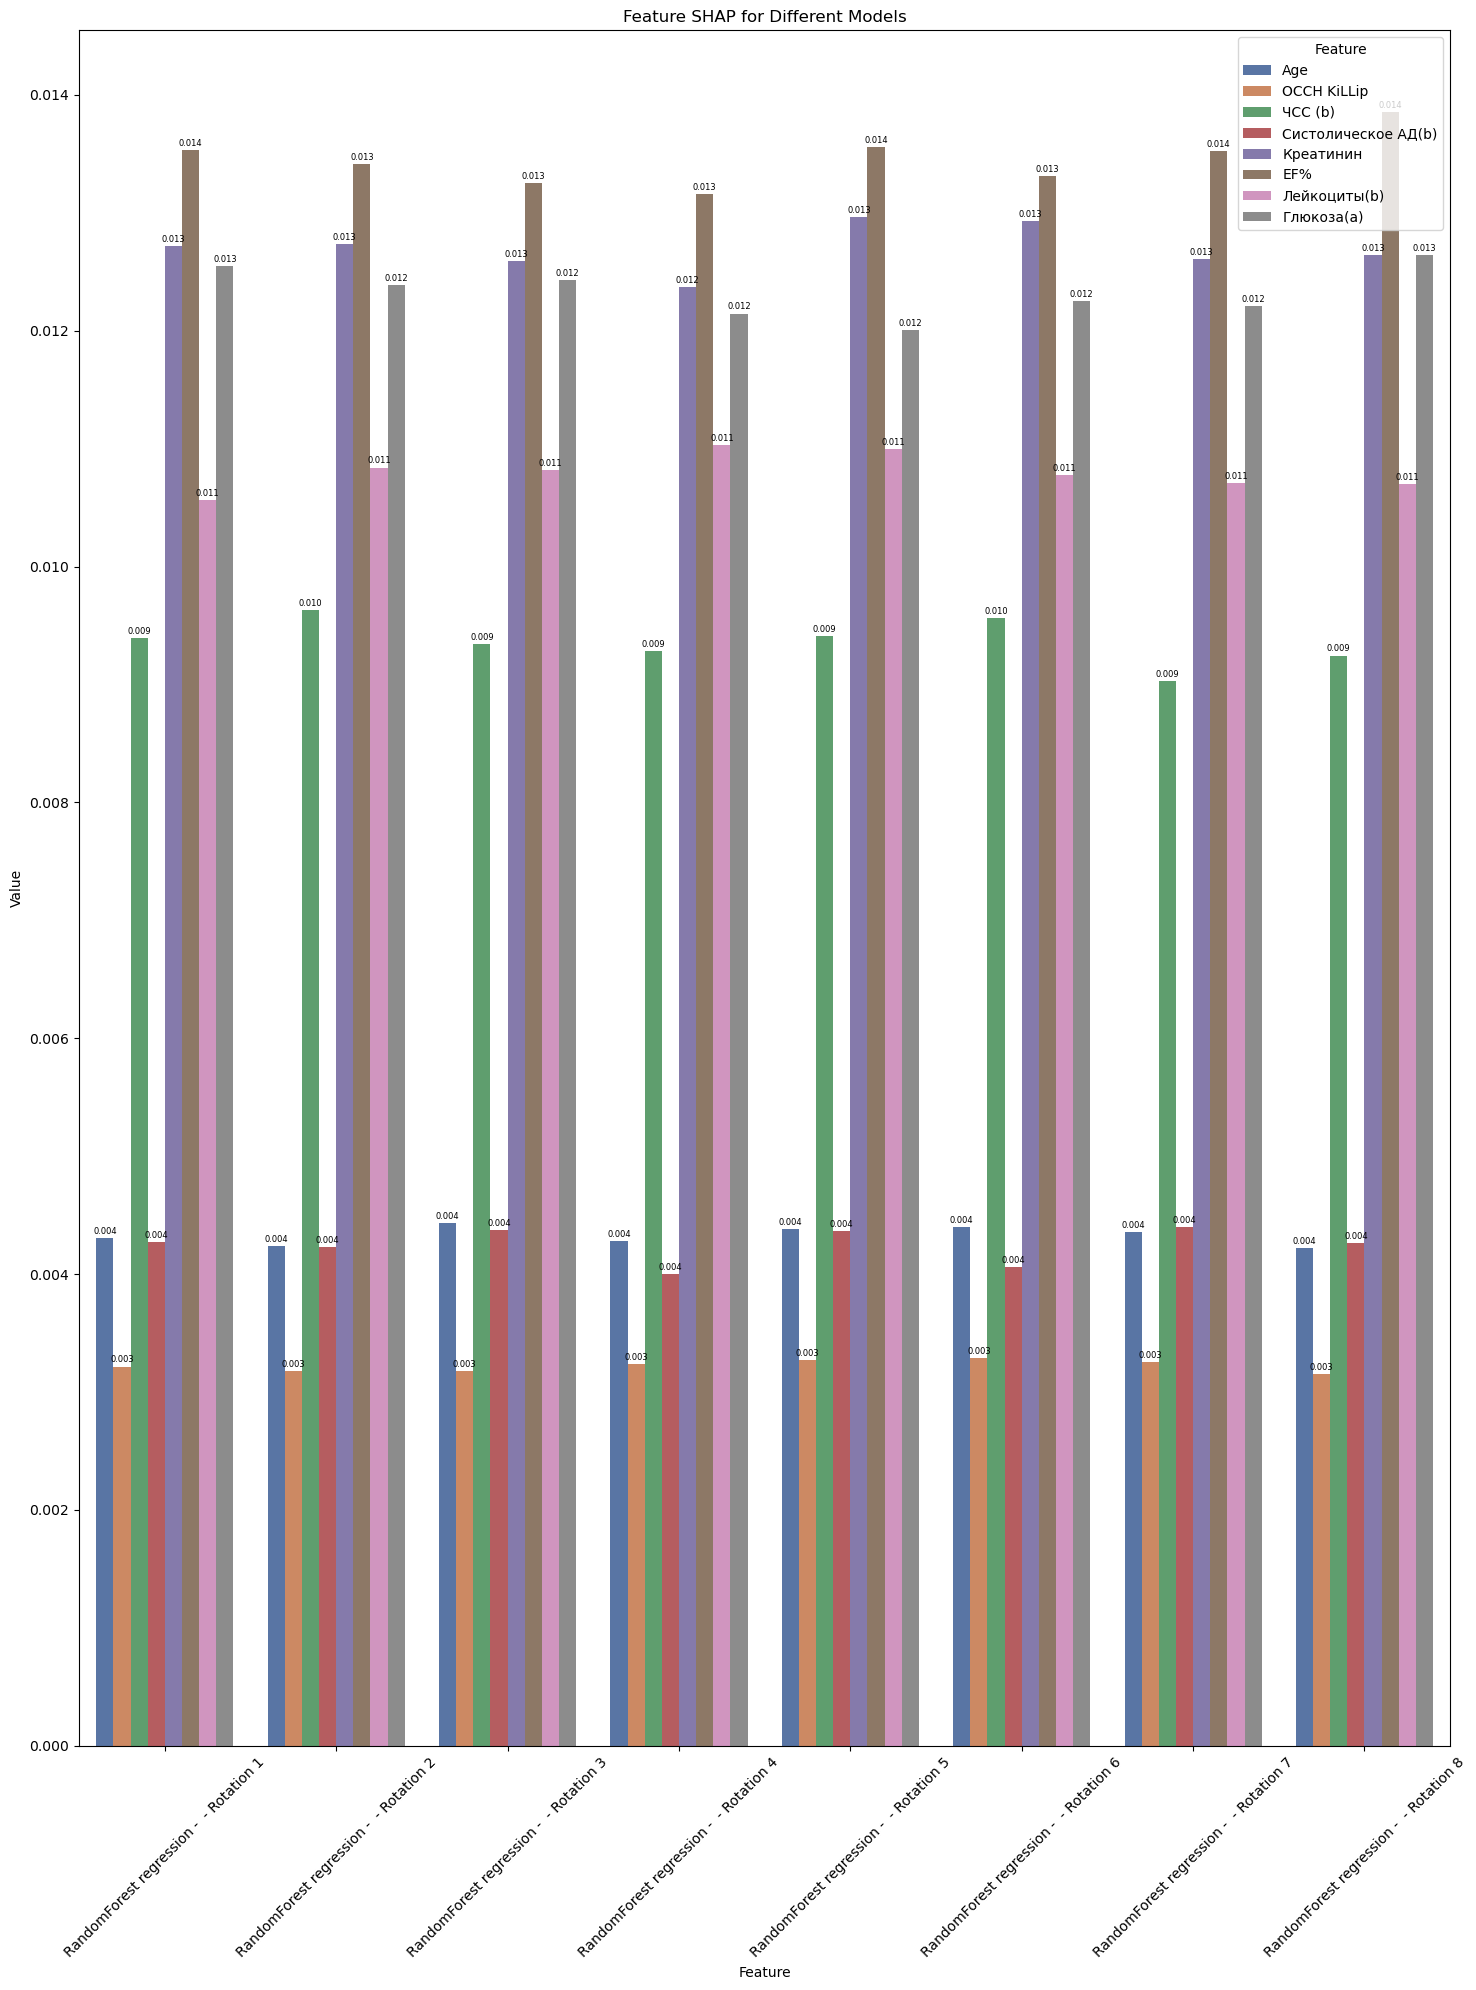

In [ ]:
plot_values(flatten_df(forest_weights_shap_df), "SHAP")

In [ ]:
combined_weights_tree_df = pd.concat([xgboost_weights_shap_df,
                                      forest_weights_shap_df
                                 ], axis=1)

In [ ]:
display(combined_weights_tree_df)
display(combined_weights_tree_df.describe())

XGBoost regression -  - Rotation 1            \
                                                Weight      SHAP   
Age                                           0.079619  0.006625   
ОССН KiLLip                                   0.081066  0.004462   
ЧСС (b)                                       0.127423  0.011177   
Систолическое АД(b)                           0.136706  0.004702   
Креатинин                                     0.156835  0.017871   
EF%                                           0.136080  0.015154   
Лейкоциты(b)                                  0.120550  0.010792   
Глюкоза(a)                                    0.161721  0.015322   

                    XGBoost regression -  - Rotation 2            \
                                                Weight      SHAP   
Age                                           0.129160  0.005841   
ОССН KiLLip                                   0.073493  0.004461   
ЧСС (b)                                       0.107963  0.011246   
Систолическое АД(b)                           0.136951  0.004567   
Креатинин                                     0.157840  0.017914   
EF%                                           0.118693  0.014408   
Лейкоциты(b)                                  0.133341  0.009705   
Глюкоза(a)                                    0.142558  0.015444   

                    XGBoost regression -  - Rotation 3            \
                                                Weight      SHAP   
Age                                           0.131091  0.005924   
ОССН KiLLip                                   0.067334  0.003895   
ЧСС (b)                                       0.105370  0.012108   
Систолическое АД(b)                           0.131080  0.004891   
Креатинин                                     0.159668  0.017277   
EF%                                           0.121270  0.013921   
Лейкоциты(b)                                  0.138515  0.009804   
Глюкоза(a)                                    0.145673  0.016328   

                    XGBoost regression -  - Rotation 4            \
                                                Weight      SHAP   
Age                                           0.106281  0.005445   
ОССН KiLLip                                   0.060953  0.002444   
ЧСС (b)                                       0.140064  0.010256   
Систолическое АД(b)                           0.094495  0.004868   
Креатинин                                     0.154070  0.018282   
EF%                                           0.139348  0.014372   
Лейкоциты(b)                                  0.138683  0.012522   
Глюкоза(a)                                    0.166105  0.016429   

                    XGBoost regression -  - Rotation 5            ...  \
                                                Weight      SHAP  ...   
Age                                           0.103124  0.005623  ...   
ОССН KiLLip                                   0.077929  0.003369  ...   
ЧСС (b)                                       0.135654  0.010415  ...   
Систолическое АД(b)                           0.130458  0.004075  ...   
Креатинин                                     0.122427  0.017952  ...   
EF%                                           0.133918  0.015045  ...   
Лейкоциты(b)                                  0.134232  0.012840  ...   
Глюкоза(a)                                    0.162259  0.016329  ...   

                    RandomForest regression -  - Rotation 4            \
                                                     Weight      SHAP   
Age                                                0.094079  0.004277   
ОССН KiLLip                                        0.034858  0.003235   
ЧСС (b)                                            0.137014  0.009281   
Систолическое АД(b)                                0.093786  0.004002   
Креатинин                                          0.183349  0.012369   
EF%                                                0.1

XGBoost regression -  - Rotation 1            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.010763   
std                             0.030792  0.005131   
min                             0.079619  0.004462   
25%                             0.110679  0.006145   
50%                             0.131752  0.010984   
75%                             0.141738  0.015196   
max                             0.161721  0.017871   

      XGBoost regression -  - Rotation 2            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.010448   
std                             0.025633  0.005199   
min                             0.073493  0.004461   
25%                             0.116011  0.005522   
50%                             0.131251  0.010475   
75%                             0.138353  0.014667   
max                             0.157840  0.017914   

      XGBoost regression -  - Rotation 3            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.010519   
std                             0.028311  0.005219   
min                             0.067334  0.003895   
25%                             0.117295  0.005666   
50%                             0.131086  0.010956   
75%                             0.140305  0.014523   
max                             0.159668  0.017277   

      XGBoost regression -  - Rotation 4            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.010577   
std                             0.034924  0.005818   
min                             0.060953  0.002444   
25%                             0.103335  0.005301   
50%                             0.139016  0.011389   
75%                             0.143565  0.014887   
max                             0.166105  0.018282   

      XGBoost regression -  - Rotation 5            ...  \
                                  Weight      SHAP  ...   
count                           8.000000  8.000000  ...   
mean                            0.125000  0.010706  ...   
std                             0.025063  0.005747  ...   
min                             0.077929  0.003369  ...   
25%                             0.117602  0.005236  ...   
50%                             0.132188  0.011627  ...   
75%                             0.134587  0.015366  ...   
max                             0.162259  0.017952  ...   

      RandomForest regression -  - Rotation 4            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.008687   
std                                  0.051500  0.004183   
min                                  0.034858  0.003235   
25%                                  0.094005  0.004208   
50%                                  0.130654  0.010156   
75%                                  0.149713  0.012202   
max                                  0.194120  0.013157   

      RandomForest regression -  - Rotation 5            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.008870   
std                                  0.051140  0.004228   
min                                  0.035561  0.003274   
25%                                  0.095632  0.004378   
50%                                  0.128746  0.010206   
75%                                  0.150629  0.012244   
max                                  0.194937  0.013559   

      RandomForest regression -  - Rotation 6            \
          

7. Deep Neural Network model

In [51]:
# Define model architecture
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01))

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Train on 4790 samples, validate on 1198 samples
Epoch 1/100
4790/4790 [==============================] - 1s 243us/sample - loss: 71.2715 - val_loss: 0.0202
Epoch 2/100
  32/4790 [..............................] - ETA: 0s - loss: 0.6721

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


4790/4790 [==============================] - 1s 140us/sample - loss: 0.2658 - val_loss: 0.0198
Epoch 3/100
4790/4790 [==============================] - 0s 93us/sample - loss: 0.1241 - val_loss: 0.0197
Epoch 4/100
4790/4790 [==============================] - 0s 102us/sample - loss: 0.0689 - val_loss: 0.0197
Epoch 5/100
4790/4790 [==============================] - 0s 98us/sample - loss: 0.1400 - val_loss: 0.0196
Epoch 6/100
4790/4790 [==============================] - 0s 86us/sample - loss: 0.0377 - val_loss: 0.0196
Epoch 7/100
4790/4790 [==============================] - 0s 87us/sample - loss: 395.8727 - val_loss: 0.0352
Epoch 8/100
4790/4790 [==============================] - 1s 117us/sample - loss: 0.0475 - val_loss: 0.0233
Epoch 9/100
4790/4790 [==============================] - 1s 149us/sample - loss: 0.0346 - val_loss: 0.0204
Epoch 10/100
4790/4790 [==============================] - 0s 104us/sample - loss: 0.0347 - val_loss: 0.0197
Epoch 11/100
4790/4790 [==========================

In [98]:
shap_algorithm = 'partition'  
mean_abs_shap_values = compute_mean_abs_shap_values(model, std_set, shap_algorithm)

# Create a DataFrame to display feature importances
feature_importances = pd.DataFrame(mean_abs_shap_values, index=X.columns, columns=["SHAP Values"])
feature_importances.sort_values(by="SHAP Values", ascending=False, inplace=True)

# Display feature importances
display(feature_importances)

Partition explainer: 1199it [16:43,  1.19it/s]                          


,SHAP Values
EF%,0.009664
Лейкоциты(b),0.005433
Age,0.005106
ОССН KiLLip,0.005004
Систолическое АД(b),0.004409
ЧСС (b),0.002606
Креатинин,0.002072
Глюкоза(a),0.001909


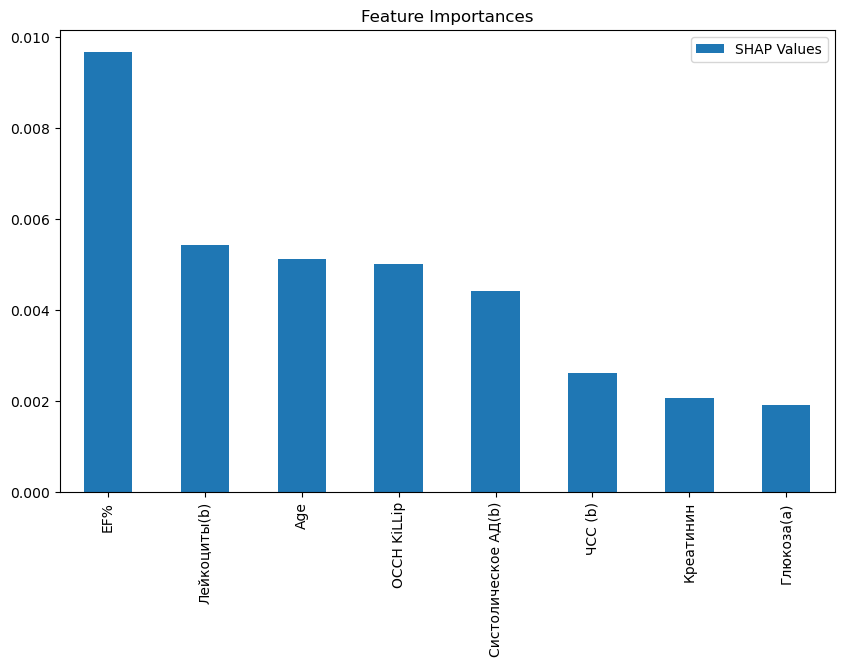

In [99]:
# Plot the feature importances
feature_importances.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances')
plt.show()